In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from plotting import plot_utils, summary_plots, load_fits, plot_prf_params, pycortex_plot_utils
plot_utils.set_all_font_sizes(12)
from utils import roi_utils, default_paths, stats_utils

import copy


In [2]:
# Gather information about the gabor feature channels

from feature_extraction import gabor_feature_extractor
n_ori=12; n_sf = 8;
_gabor_ext_complex = gabor_feature_extractor.gabor_extractor_multi_scale(n_ori=n_ori, n_sf=n_sf)

sf_cyc_per_stim = _gabor_ext_complex.feature_table['SF: cycles per stim']
screen_eccen_deg=8.4
sf_cyc_per_deg = sf_cyc_per_stim/screen_eccen_deg
sf_unique, sf_inds = np.unique(sf_cyc_per_deg, return_inverse=True)
n_sf = len(sf_unique)

ori_deg = _gabor_ext_complex.feature_table['Orientation: degrees']
ori_unique, orient_inds = np.unique(ori_deg, return_inverse=True)
n_ori = len(ori_unique)

In [3]:
sfs_cyc_per_stim = np.logspace(np.log10(_gabor_ext_complex.sf_range_cyc_per_stim[0]), \
                               np.log10(_gabor_ext_complex.sf_range_cyc_per_stim[1]),num = _gabor_ext_complex.n_sf)
resized_sizes = np.round(sfs_cyc_per_stim * _gabor_ext_complex.pix_per_cycle).astype('int')
actual_freqs = resized_sizes/ _gabor_ext_complex.pix_per_cycle

_gabor_ext_complex.sizes_to_resample_each_scale
actual_freqs/8.4

array([0.34590107, 0.57650179, 0.89357777, 1.38360429, 2.19070679,
       3.45901072, 5.44794189, 8.56105154])

In [4]:
# Load results of the fitting procedure
subjects = np.arange(1,9)
# subjects=[1]
n_subjects = len(subjects)

fitting_type = 'gabor_solo_ridge_12ori_8sf'

out = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, n_from_end=0, \
                                  verbose=False) \
       for ss in subjects]
fig_save_folder=None

skip_inds = [4,5,7,11,12, 19,20, 22, 24]
roi_def = roi_utils.multi_subject_roi_def(subjects, skip_areas=skip_inds)
roi_names =roi_def.roi_names
n_rois = len(roi_names)

In [194]:
out[0]['zscore_features']

True

In [5]:

feature_weights = np.concatenate([out[si]['best_params'][1][:,:,0] for si in range(n_subjects)], axis=0)
feature_corr = np.concatenate([out[si]['corr_each_feature'] for si in range(n_subjects)], axis=0)

n_voxels = feature_weights.shape[0]

allw_reshaped = np.reshape(feature_weights, [n_voxels, n_ori, n_sf], order='F')
mean_orient_weights = np.mean(allw_reshaped, axis=2)
print(np.shape(mean_orient_weights))
mean_sf_weights = np.mean(allw_reshaped, axis=1)
print(np.shape(mean_sf_weights))

allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
print(np.shape(mean_orient_corr))
mean_sf_corr = np.mean(allcorr_reshaped, axis=1)
print(np.shape(mean_sf_corr))

(150842, 12)
(150842, 8)
(150842, 12)
(150842, 8)


In [6]:
# find maxes. if they are constant across orient/SF, then set to nan.
preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_orient_corr[:,0:1], [1,n_ori])==mean_orient_corr, axis=1)
preferred_ori_corr[is_constant] = np.nan

preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_sf_corr[:,0:1], [1,n_sf])==mean_sf_corr, axis=1)
preferred_sf_corr[is_constant] = np.nan

preferred_ori_weights = np.argmax(mean_orient_weights, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_orient_weights[:,0:1], [1,n_ori])==mean_orient_weights, axis=1)
preferred_ori_weights[is_constant] = np.nan

preferred_sf_weights = np.argmax(mean_sf_weights, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_sf_weights[:,0:1], [1,n_sf])==mean_sf_weights, axis=1)
preferred_sf_weights[is_constant] = np.nan

0.3565896056935289


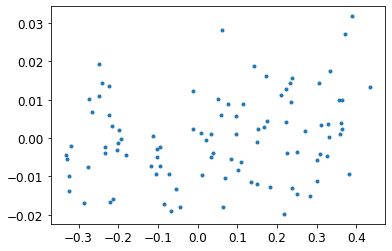

In [204]:
# about how well are the weights for different channels aligned with the correlation coefficient 
# measure of feature tuning?
correspondence = [np.corrcoef(feature_weights[ii,:], feature_corr[ii,:])[0,1] for ii in range(n_voxels)]
print(np.mean(correspondence) )

# correlation and weights don't necessarily correspond.
vidx = np.random.choice(np.arange(n_voxels),1)
plt.plot(allcorr_reshaped[vidx,:,:].ravel(), allw_reshaped[vidx,:,:].ravel(),'.')

In [8]:
# Make plots in pycortex for variance partitioning analysis
# Full variance partition over all subsets

import cortex
from utils import numpy_utils

port=44442

title = 'Gabor model tuning estimates, %s'%(summary_plots.get_substr(out));

names = []
maps = []
cmaps = []
mins = []
maxes = []
vox2plot = []
subject_map_inds = []
map_sequence = []

n_vox_each = [out[si]['val_r2'].shape[0] for si in range(n_subjects)]
sub_inds = np.concatenate([si*np.ones(n_vox_each[si],) for si in range(n_subjects)], axis=0)

for si, ss in enumerate(subjects):

    names += ['S%d: Gabor model accuracy (sqrt R2)'%ss]
    maps += [np.sqrt(out[si]['val_r2'][:,0])]
    cmaps += ['PuBu']
    mins += [0]
    maxes += [0.60]

    ori_pref = ori_unique[preferred_ori_corr[sub_inds==si].astype('int')]
    freq_pref = sf_unique[preferred_sf_corr[sub_inds==si].astype('int')]
    maps += [ori_pref, freq_pref]
    names += ['S%d: Preferred orientation (deg)'%ss, 'S%d: Preferred spatial frequency (cyc/deg)'%ss]
    cmaps += ['Retinotopy_RYBCR', 'viridis']
    mins += [0, 0]
    maxes += [180, 9]

    vox2plot.append(out[si]['val_r2'][:,0]>0.01)
    
    n_new_maps = int(len(names)/(si+1))
    subject_map_inds += [si for ii in range(n_new_maps)]
    map_sequence += [ni for ni in range(n_new_maps)]

# putting them into a nicer order (want same type of map near each other to compare subs)
_, new_order = numpy_utils.double_sort(np.arange(len(maps)), map_sequence, subject_map_inds)
names = [names[ni] for ni in new_order]
cmaps = [cmaps[ni] for ni in new_order]
mins = [mins[ni] for ni in new_order]
maxes = [maxes[ni] for ni in new_order]
maps = [maps[ni] for ni in new_order]
subject_map_inds = [subject_map_inds[ni] for ni in new_order]


voxel_mask = [o['voxel_mask'] for o in out]
nii_shape = [o['brain_nii_shape'] for o in out]
volume_space = out[0]['volume_space']

pycortex_plot_utils.plot_maps_pycortex(subjects, port, maps, names, subject_map_inds=subject_map_inds, \
                        mins=mins, maxes=maxes, cmaps=cmaps, \
                        title=title, vox2plot = vox2plot, roi_def=None, \
                        voxel_mask =voxel_mask, \
                        nii_shape = nii_shape, \
                        volume_space=volume_space)

/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


navigate browser to: 127.0.0.1:44442
Started server on port 44442


<JS: window.viewer>

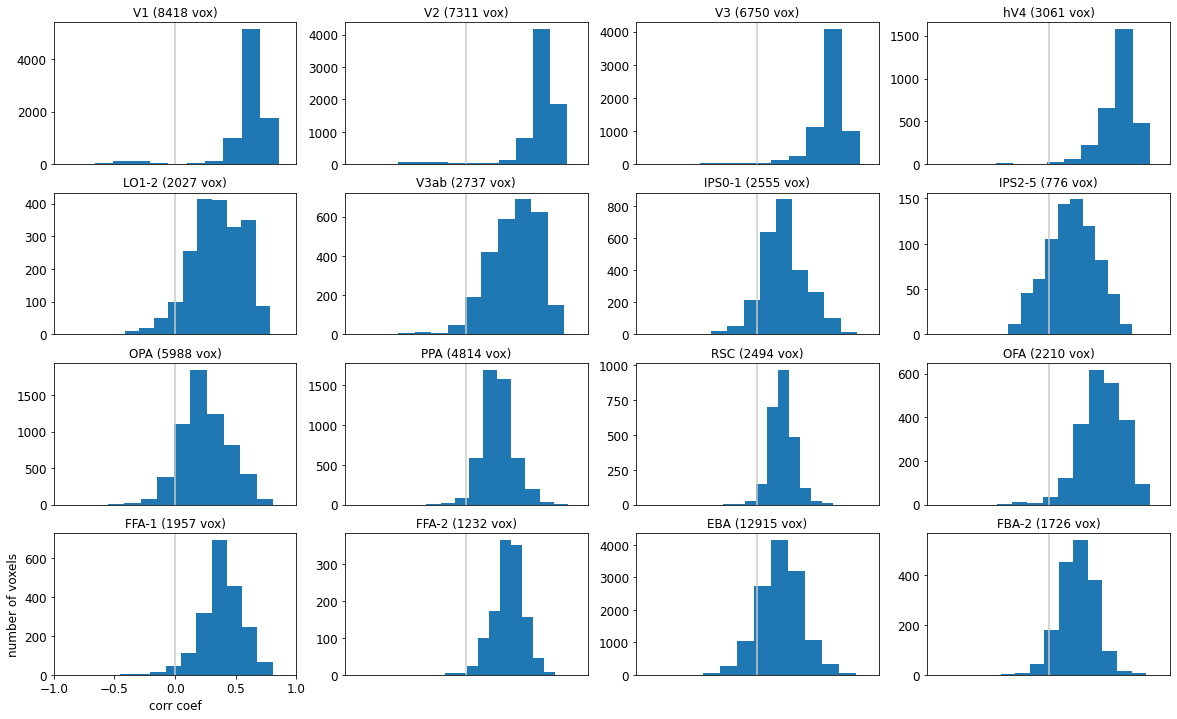

In [230]:
# plotting the distribution of voxel's maximum corr coef, for any orientation

r2_cutoff = 0.01
val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
abv_thresh = val_r2>r2_cutoff

plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil((n_rois)/npy))

pi=0
for ri in range(n_rois):

    inds_this_roi = roi_def.get_indices(ri) & abv_thresh
    
    pi+=1
    plt.subplot(npx,npy,pi)

    vals = np.max(mean_orient_corr[inds_this_roi], axis=1)
    
    plt.hist(vals)
    plt.xlim([-1,1])

    if pi==(npx-1)*npy+1:
        plt.xlabel('corr coef')
        plt.ylabel('number of voxels')
    else:
        plt.xticks([]);

    plt.axvline(0,color=[0.8, 0.8, 0.8])

    plt.title('%s (%d vox)'%(roi_names[ri], np.sum(inds_this_roi)))


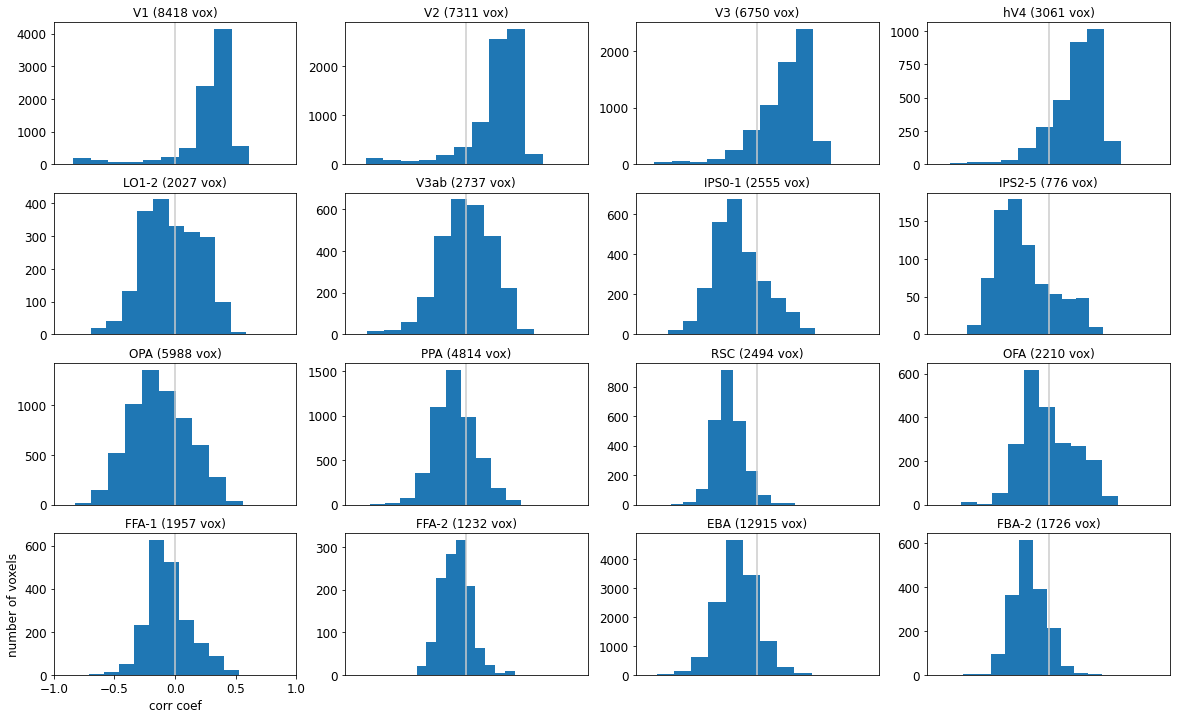

In [229]:
# plotting the distribution of voxel's minimum corr coef, for any orientation

r2_cutoff = 0.01
val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
abv_thresh = val_r2>r2_cutoff

plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil((n_rois)/npy))

pi=0
for ri in range(n_rois):

    inds_this_roi = roi_def.get_indices(ri) & abv_thresh
    
    pi+=1
    plt.subplot(npx,npy,pi)

    vals = np.min(mean_orient_corr[inds_this_roi], axis=1)
    
    plt.hist(vals)
    plt.xlim([-1,1])

    if pi==(npx-1)*npy+1:
        plt.xlabel('corr coef')
        plt.ylabel('number of voxels')
    else:
        plt.xticks([]);

    plt.axvline(0,color=[0.8, 0.8, 0.8])

    plt.title('%s (%d vox)'%(roi_names[ri], np.sum(inds_this_roi)))


In [173]:
mean_orient_corr.shape

peaks = get_circ_peaks(mean_orient_corr)
troughs = get_circ_troughs(mean_orient_corr)

n_peaks = np.array([len(p) for p in peaks])
n_troughs = np.array([len(t) for t in troughs])

max_n_peaks = np.max(n_peaks)

In [223]:
import scipy.stats

peak_ratios = np.full(shape=(n_voxels,max_n_peaks),fill_value=np.nan)
n_peaks_nonneg = np.zeros((n_voxels,))
thresh = 0.50
n_peaks_abovethresh = np.zeros((n_voxels,))

for vi in range(n_voxels):

    peak_vals = mean_orient_corr[vi,peaks[vi]]
    peak_vals_nonneg = peak_vals[peak_vals>=0]
    n_peaks_nonneg[vi] = len(peak_vals_nonneg)
    
    if len(peak_vals_nonneg)>0:
        
        sorted_vals = np.flip(np.sort(peak_vals_nonneg))
        pr = sorted_vals / sorted_vals[0]
        
        peak_ratios[vi,0:len(peak_vals_nonneg)] = pr
      
        n_peaks_abovethresh[vi] = np.sum(pr>thresh)

In [227]:
peak_ratios[vidx,:]

array([1.        , 0.24473395,        nan,        nan,        nan,
              nan])

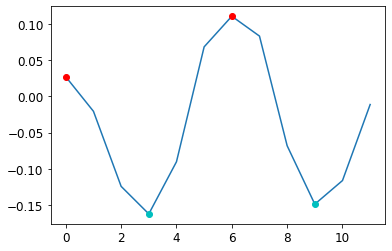

In [226]:
vidx = np.where((n_peaks_abovethresh==1) & (n_peaks==2))[0][1]
corr_profile = mean_orient_corr[vidx,:]
plt.figure();
plt.plot(corr_profile)
plt.plot(peaks[vidx], corr_profile[peaks[vidx]],'o',color='r')
plt.plot(troughs[vidx], corr_profile[troughs[vidx]],'o',color='c')

In [220]:
n_peaks_abovethresh[vidx]

1.0

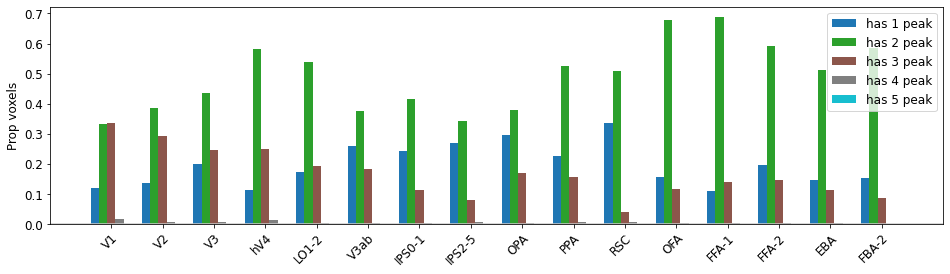

In [214]:
prop_n_peaks = np.zeros((n_rois,np.max(n_peaks)),dtype=int)
for ri in range(n_rois):
    inds = roi_def.get_indices(ri)
    for pp in range(np.max(n_peaks)):
#         prop_n_peaks[ri,pp] = np.sum(n_peaks_abovethresh[inds]==pp)
        prop_n_peaks[ri,pp] = np.sum(n_peaks_nonneg[inds]==pp)
    
prop_n_peaks = prop_n_peaks/np.sum(prop_n_peaks, axis=1, keepdims=True)
mean_vals = prop_n_peaks[:,1:]
labels = ['has %d peak'%pp for pp in np.arange(1,6)]

fh = plot_utils.plot_multi_bars(mean_data=mean_vals, space=0.1, \
                xticklabels=roi_names, ylabel='Prop voxels', \
                ylim=[], title='', horizontal_line_pos=0,\
                legend_labels=labels, \
                legend_overlaid=True, legend_separate=False, \
                fig_size=(16,4))

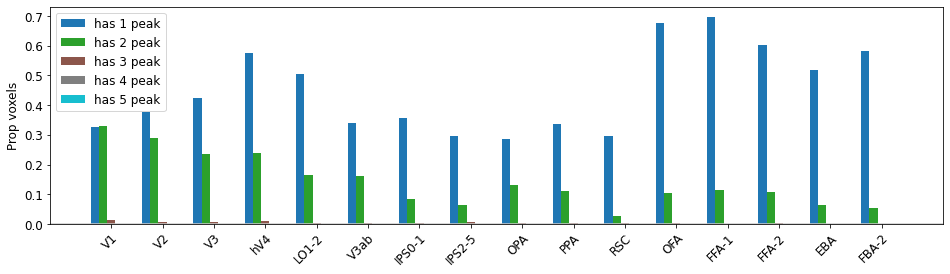

In [215]:
prop_n_peaks = np.zeros((n_rois,np.max(n_peaks)),dtype=int)
for ri in range(n_rois):
    inds = roi_def.get_indices(ri)
    for pp in range(np.max(n_peaks)):
        prop_n_peaks[ri,pp] = np.sum(n_peaks_abovethresh[inds]==pp)
#         prop_n_peaks[ri,pp] = np.sum(n_peaks_nonneg[inds]==pp)
    
prop_n_peaks = prop_n_peaks/np.sum(prop_n_peaks, axis=1, keepdims=True)
mean_vals = prop_n_peaks[:,1:]
labels = ['has %d peak'%pp for pp in np.arange(1,6)]

fh = plot_utils.plot_multi_bars(mean_data=mean_vals, space=0.1, \
                xticklabels=roi_names, ylabel='Prop voxels', \
                ylim=[], title='', horizontal_line_pos=0,\
                legend_labels=labels, \
                legend_overlaid=True, legend_separate=False, \
                fig_size=(16,4))

In [212]:
np.max(n_peaks_nonneg)

6.0

In [196]:
vi=0;
mean_orient_corr[vi,peaks[vi]]

array([-0.13230666, -0.26144622, -0.12078635])

In [209]:
np.sum(~np.isnan(peak_ratios), axis=0)

array([124976,  95237,  27124,    921,     13,      2])

In [184]:
a = 0.15
b = 0.10

b/a

0.6666666666666667

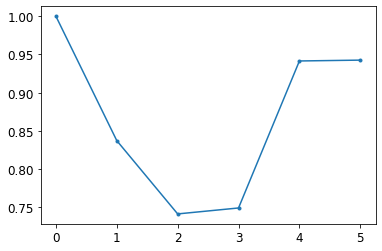

In [208]:
plt.figure();
plt.plot(np.nanmean(peak_ratios, axis=0),'.-')

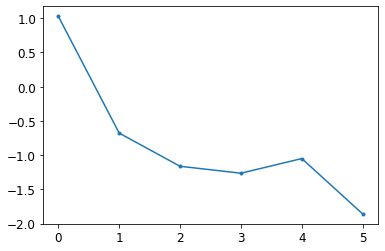

In [166]:
plt.figure();
plt.plot(np.nanmean(sorted_peak_activs, axis=0),'.-')

In [163]:
np.where(n_peaks==3)[0].shape

(35842,)

In [148]:
prop_n_peaks = np.zeros((n_rois,np.max(n_peaks)),dtype=int)
for ri in range(n_rois):
    inds = roi_def.get_indices(ri)
    for pp in range(np.max(n_peaks)):
        prop_n_peaks[ri,pp] = np.sum(n_peaks[inds]==pp)
    

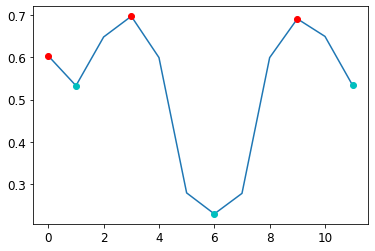

In [171]:
vinds = np.where((n_peaks==3) & roi_def.get_indices(0))[0]
vidx = np.random.choice(vinds,1)[0]
corr_profile = mean_orient_corr[vidx,:]
plt.figure();
plt.plot(corr_profile)
plt.plot(peaks[vidx], corr_profile[peaks[vidx]],'o',color='r')
plt.plot(troughs[vidx], corr_profile[troughs[vidx]],'o',color='c')

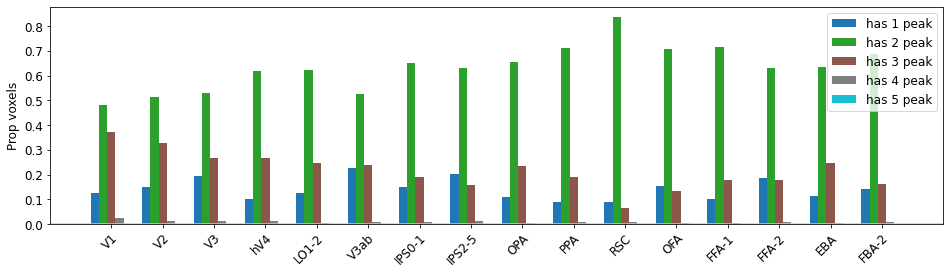

In [168]:
prop_n_peaks = prop_n_peaks/np.sum(prop_n_peaks, axis=1, keepdims=True)
mean_vals = prop_n_peaks[:,1:]
labels = ['has %d peak'%pp for pp in np.arange(1,6)]

fh = plot_utils.plot_multi_bars(mean_data=mean_vals, space=0.1, \
                xticklabels=roi_names, ylabel='Prop voxels', \
                ylim=[], title='', horizontal_line_pos=0,\
                legend_labels=labels, \
                legend_overlaid=True, legend_separate=False, \
                fig_size=(16,4))

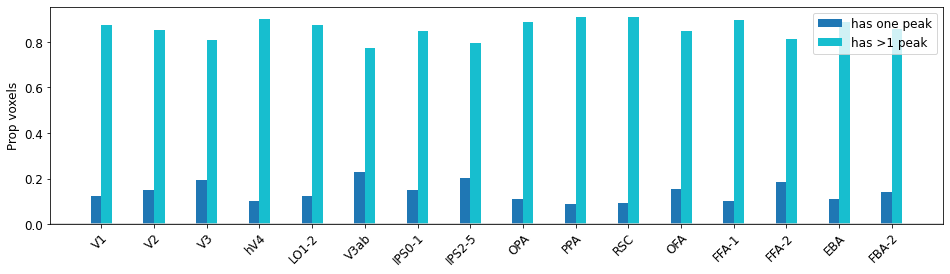

In [151]:
prop_n_peaks = prop_n_peaks/np.sum(prop_n_peaks, axis=1, keepdims=True)
mean_vals = np.concatenate([prop_n_peaks[:,1:2], np.sum(prop_n_peaks[:,2:], axis=1, keepdims=True)], axis=1)

fh = plot_utils.plot_multi_bars(mean_data=mean_vals, space=0.3, \
                xticklabels=roi_names, ylabel='Prop voxels', \
                ylim=[], title='', horizontal_line_pos=0,\
                legend_labels=['has one peak', 'has >1 peak'], \
                legend_overlaid=True, legend_separate=False, \
                fig_size=(16,4))

In [123]:
peaks[0]

array([3, 6, 9])

In [124]:
troughs[0]

array([0, 5, 7])

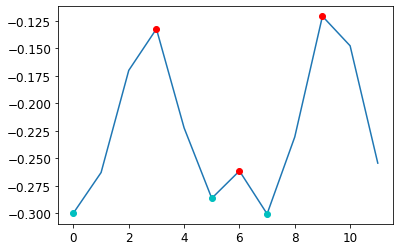

In [197]:
vidx = 0
corr_profile = mean_orient_corr[vidx,:]
plt.figure();
plt.plot(corr_profile)
plt.plot(peaks[vidx], corr_profile[peaks[vidx]],'o',color='r')
plt.plot(troughs[vidx], corr_profile[troughs[vidx]],'o',color='c')

(array([2.1869e+04, 9.1641e+04, 3.5842e+04, 1.4610e+03, 2.9000e+01]),
 array([1., 2., 3., 4., 5., 6.]),
 <BarContainer object of 5 artists>)

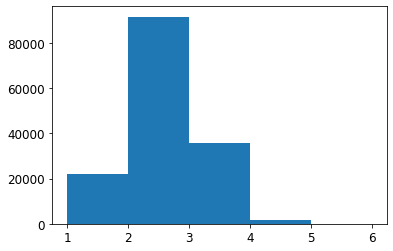

In [122]:
plt.figure();
plt.hist(n_troughs, 5)

In [100]:
curve = mean_orient_corr[0:2,:]

circ_diffs = np.diff(np.concatenate([curve, curve[:,0:1]], axis=1), axis=1)
circ_diffs_shifted = np.roll(circ_diffs, shift=1, axis=1)

In [103]:
peaks = [np.where((circ_diffs[ii,:]<0) & (circ_diffs_shifted[ii,:]>0))[0]

TypeError: where() got an unexpected keyword argument 'axis'

In [117]:
def get_circ_peaks(curves):
    
    if len(curves.shape)==1:
        curves = curves[np.newaxis,:]
    circ_diffs = np.diff(np.concatenate([curves, curves[:,0:1]], axis=1), axis=1)
    circ_diffs_shifted = np.roll(circ_diffs, shift=1, axis=1)
    peaks = [ np.where((circ_diffs[ii,:]<0) & (circ_diffs_shifted[ii,:]>0))[0] for ii in range(curves.shape[0])]
    
    return peaks

def get_circ_troughs(curve):
    
    return get_circ_peaks(curve*(-1))

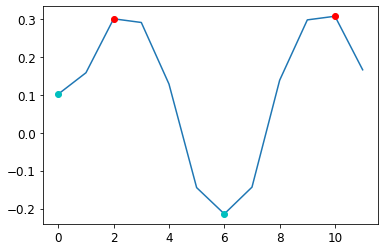

In [119]:
# rname='PPA'
rname = 'FFA-2'
val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
vinds = np.where(roi_def.get_indices_from_name(rname))[0]
vidx = vinds[np.flip(np.argsort(val_r2[vinds]))[0]]

corr_profile = mean_orient_corr[vidx,:]
plt.figure();
plt.plot(corr_profile)
peaks = get_circ_peaks(corr_profile)[0]
troughs = get_circ_troughs(corr_profile)[0]

plt.plot(peaks, corr_profile[peaks],'o',color='r')
plt.plot(troughs, corr_profile[troughs],'o',color='c')

In [87]:
get_circ_peaks(corr_profile)

array([0, 6])

array([3, 9])

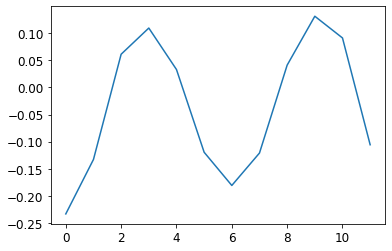

In [88]:
plt.figure();
plt.plot((-1)*corr_profile)
get_circ_peaks((-1)*corr_profile)

0.3642304279437196

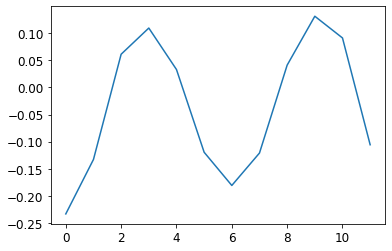

In [72]:
corr_profile = copy.deepcopy(mean_orient_corr[vidx,:])
corr_profile -= 1
plt.figure();
plt.plot(corr_profile)
# selectivity_index = (np.max(corr_profile) - np.min(corr_profile))/ \
#                     (np.max(corr_profile) + np.min(corr_profile))
selectivity_index = (np.max(corr_profile) - np.min(corr_profile))
selectivity_index

In [44]:
sorted_inds = np.flip(np.argsort(corr_profile))
first_peak = sorted_inds[0]
# first_peak=11
print(sorted_inds)
peak_pad=1
sorted_inds_adj = sorted_inds[(np.abs(sorted_inds-first_peak)>peak_pad) & \
                              (np.abs(sorted_inds-(first_peak+len(sorted_inds)))>peak_pad) & \
                              (np.abs(sorted_inds-(first_peak-len(sorted_inds)))>peak_pad)]
print(sorted_inds_adj)
second_peak = sorted_inds_adj[0]
[first_peak, second_peak]

[ 0  6  1  7  5 11  4  8  2 10  3  9]
[ 6  7  5  4  8  2 10  3  9]


[0, 6]

In [71]:
peaks = get_circ_peaks((-1)*corr_profile)
peaks

array([3, 9])

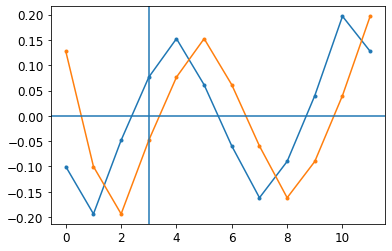

In [66]:
plt.figure();
plt.plot(circ_diffs,'.-')
plt.plot(circ_diffs_shifted,'.-')
plt.axhline(0)
plt.axvline(3)

In [ ]:
diffs = np.diff(np.concatenate([corr_profile, corr_profile[]]))

In [19]:
ori_unique[np.flip(np.argsort(corr_profile))[0:2]]

array([135.,  45.])

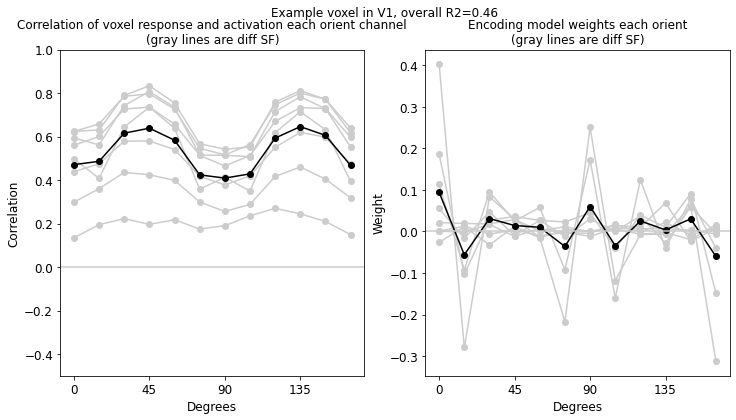

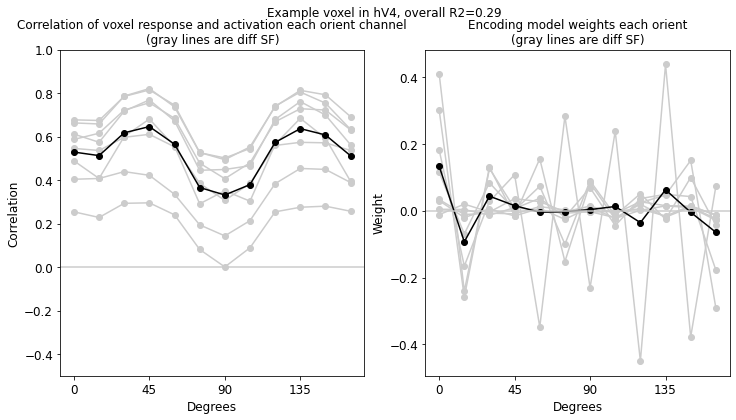

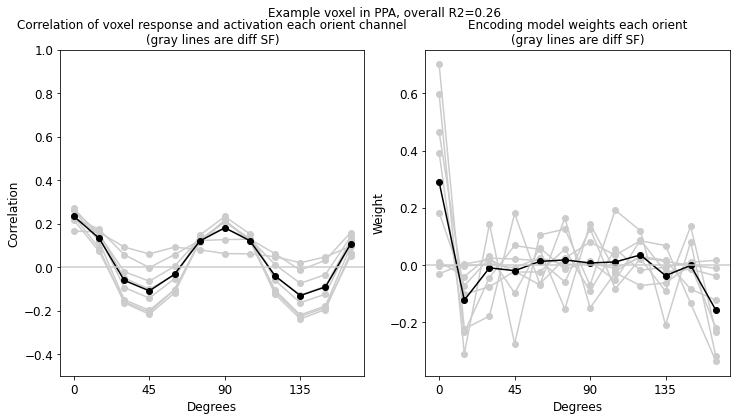

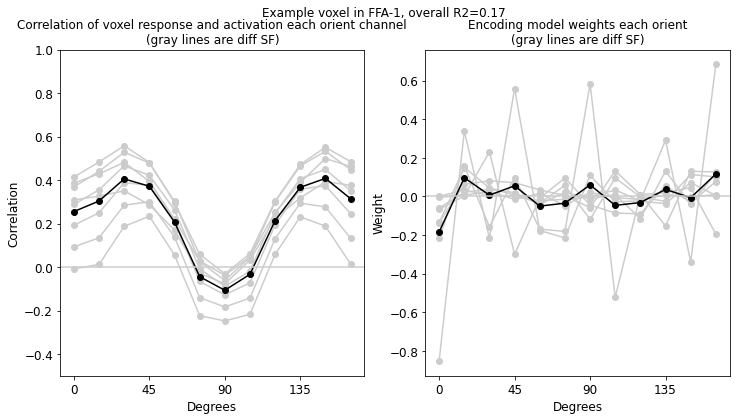

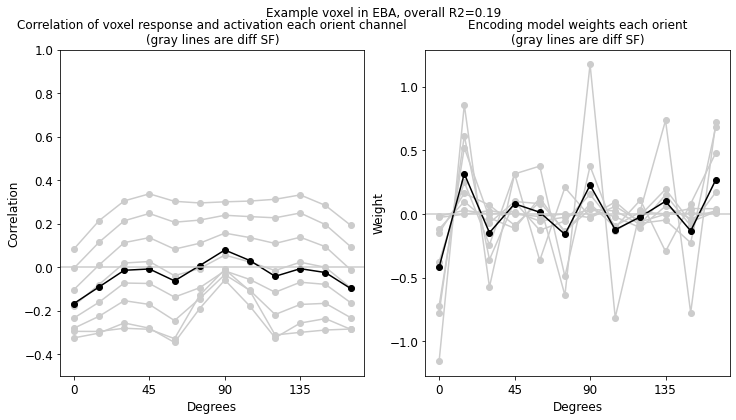

In [205]:
# Plotting orientation tuning for some example voxels

plot_utils.set_all_font_sizes(12)

si = 0;

val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)

rnames = ['V1', 'hV4', 'PPA', 'FFA-1', 'EBA']

for rname in rnames:

    vinds = np.where(roi_def.get_indices_from_name(rname))[0]

    vidx = vinds[np.flip(np.argsort(val_r2[vinds]))[0]]

    plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.plot(ori_unique, allcorr_reshaped[vidx,:,:],'-o',color=[0.8, 0.8, 0.8])
    plt.plot(ori_unique,  mean_orient_corr[vidx,:],'-o',color='k')
    plt.xlabel('Degrees')
    plt.ylabel('Correlation')
    plt.title('Correlation of voxel response and activation each orient channel\n(gray lines are diff SF)')
    # plt.axhline(val_cc[vidx],color='k')
    plt.axhline(0, color=[0.8, 0.8, 0.8])
    plt.xticks(np.arange(0,179,45))
    plt.ylim([-0.5,1])

    plt.subplot(1,2,2)
    plt.plot(ori_unique, allw_reshaped[vidx,:,:],'-o',color=[0.8, 0.8, 0.8])
    plt.plot(ori_unique, mean_orient_weights[vidx,:],'-o',color='k')
    plt.xlabel('Degrees')
    plt.ylabel('Weight')
    plt.title('Encoding model weights each orient\n(gray lines are diff SF)')
    plt.axhline(0, color=[0.8, 0.8, 0.8])
    plt.xticks(np.arange(0,179,45))
    # plt.ylim([-1,1])

    plt.suptitle('Example voxel in %s, overall R2=%.2f'%(rname, val_r2[vidx]));



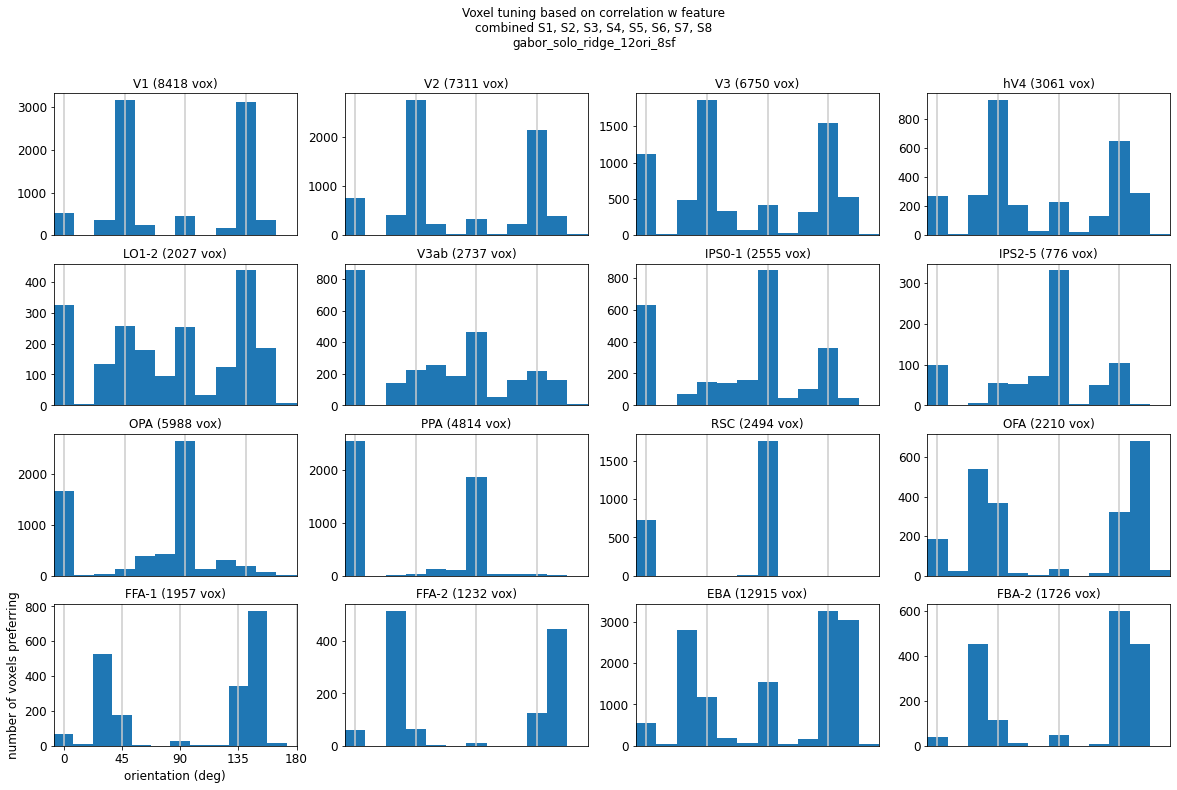

In [206]:
# Plot histograms of "preferred orientation"
# based on correlation coefficient method

r2_cutoff = 0.01

val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)

abv_thresh = val_r2>r2_cutoff

plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil((n_rois)/npy))

pi=0
for ri in range(n_rois):

    inds_this_roi = roi_def.get_indices(ri) & abv_thresh
    
    pi+=1
    plt.subplot(npx,npy,pi)

    spacing = ori_unique[1] - ori_unique[0]
    neach = [np.sum(preferred_ori_corr[inds_this_roi]==oo) for oo in range(n_ori)]
    plt.bar(ori_unique, neach, width=spacing)

    plt.xlim([-spacing/2,180-spacing/2])

    if pi==(npx-1)*npy+1:
        plt.xlabel('orientation (deg)')
        plt.ylabel('number of voxels preferring')
        plt.xticks(np.arange(0,181,45))
    else:
        plt.xticks([]);
#         plt.yticks([])

    for ii in np.arange(0,181,45):
        plt.axvline(ii,color=[0.8, 0.8, 0.8])

    plt.title('%s (%d vox)'%(roi_names[ri], np.sum(inds_this_roi)))

plt.suptitle('Voxel tuning based on correlation w feature\n%s\n%s'%(summary_plots.get_substr(out), fitting_type));


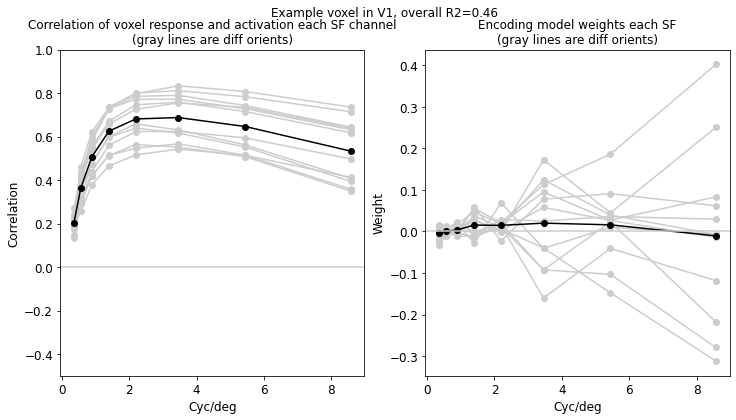

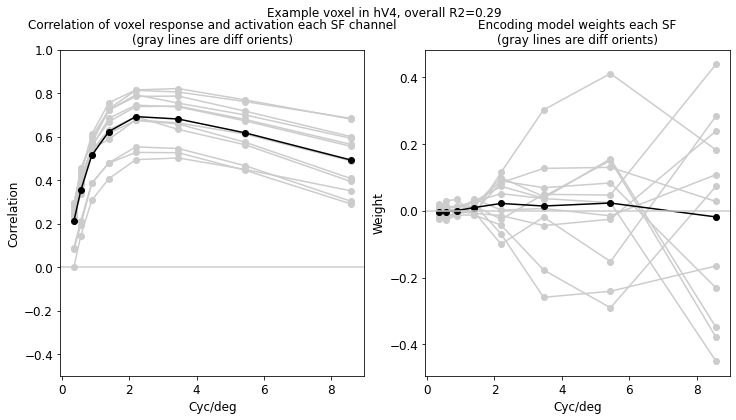

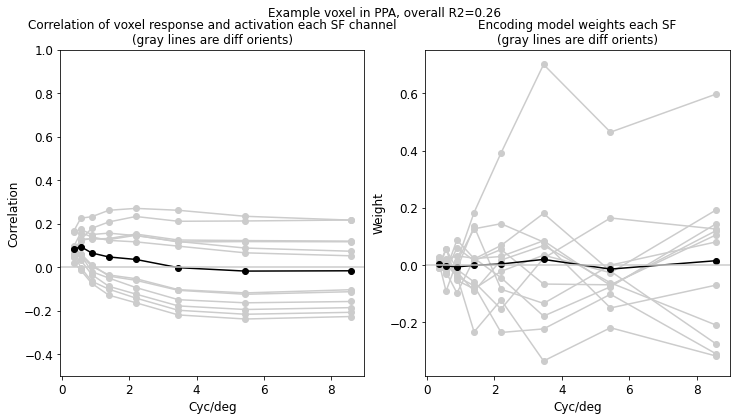

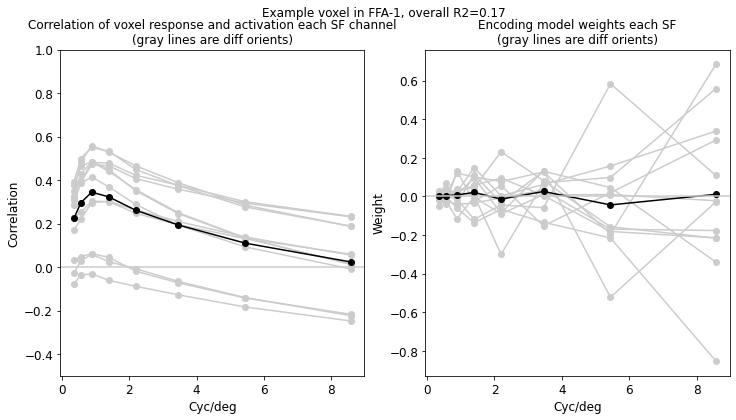

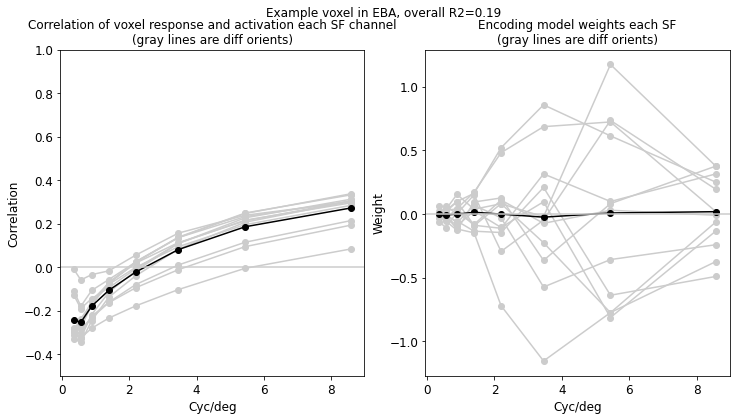

In [207]:
# Plotting spatial frequency tuning for some example voxels

plot_utils.set_all_font_sizes(12)

si = 0;

val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)

rnames = ['V1', 'hV4', 'PPA','FFA-1','EBA']

for rname in rnames:

    vinds = np.where(roi_def.get_indices_from_name(rname))[0]

    vidx = vinds[np.flip(np.argsort(val_r2[vinds]))[0]]

    plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.plot(sf_unique, allcorr_reshaped[vidx,:,:].T,'-o',color=[0.8, 0.8, 0.8])
    plt.plot(sf_unique,  mean_sf_corr[vidx,:],'-o',color='k')
    plt.xlabel('Cyc/deg')
    plt.ylabel('Correlation')
    plt.title('Correlation of voxel response and activation each SF channel\n(gray lines are diff orients)')
    # plt.axhline(val_cc[vidx],color='k')
    plt.axhline(0, color=[0.8, 0.8, 0.8])
   
    plt.ylim([-0.5,1])

    plt.subplot(1,2,2)
    plt.plot(sf_unique, allw_reshaped[vidx,:,:].T,'-o',color=[0.8, 0.8, 0.8])
    plt.plot(sf_unique, mean_sf_weights[vidx,:],'-o',color='k')
    plt.xlabel('Cyc/deg')
    plt.ylabel('Weight')
    plt.title('Encoding model weights each SF\n(gray lines are diff orients)')
    plt.axhline(0, color=[0.8, 0.8, 0.8])
   
    plt.suptitle('Example voxel in %s, overall R2=%.2f'%(rname, val_r2[vidx]));



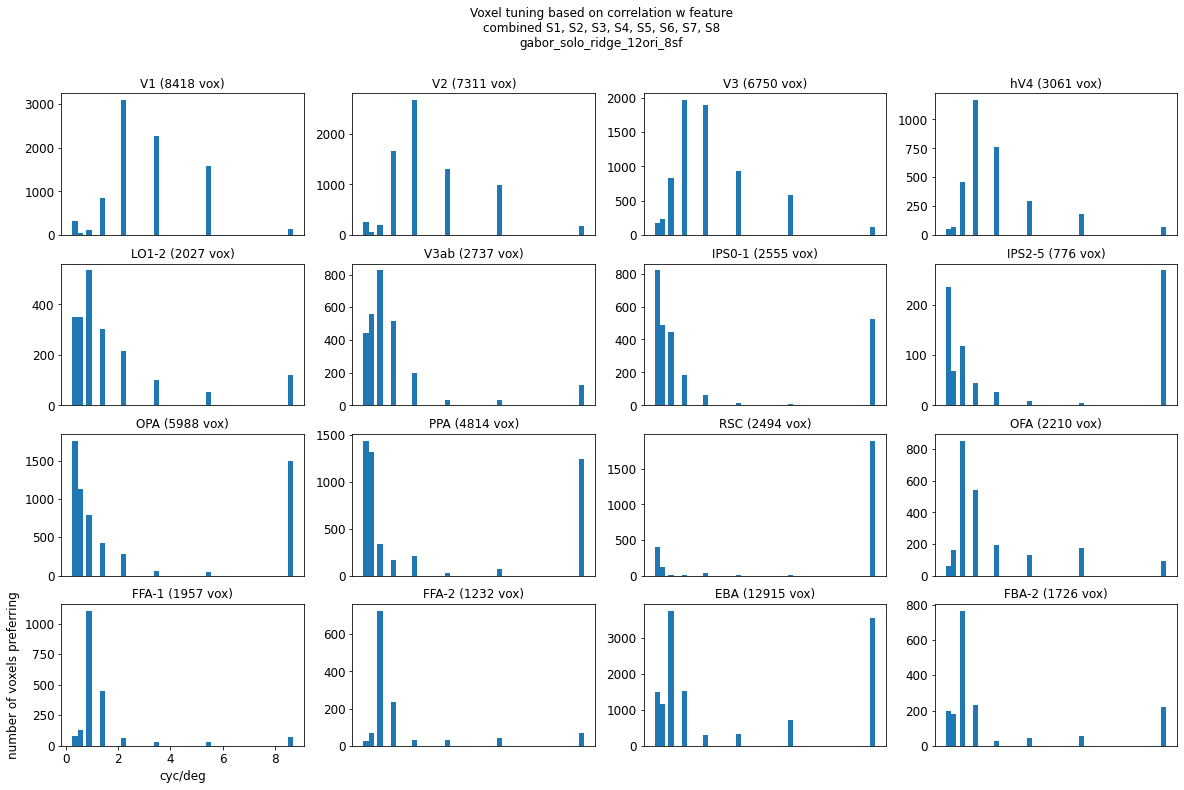

In [208]:
# Plot histograms of "preferred frequency"
# based on correlation coefficient method

r2_cutoff = 0.01

val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)

abv_thresh = val_r2>r2_cutoff

plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil((n_rois)/npy))

pi=0
for ri in range(n_rois):

    inds_this_roi = roi_def.get_indices(ri) & abv_thresh
    
    pi+=1
    plt.subplot(npx,npy,pi)

    spacing = sf_unique[1] - sf_unique[0]
    neach = [np.sum(preferred_sf_corr[inds_this_roi]==ff) for ff in range(n_sf)]
    plt.bar(sf_unique, neach, width=spacing)

#     plt.xlim([-spacing/2,180-spacing/2])

    if pi==(npx-1)*npy+1:
        plt.xlabel('cyc/deg')
        plt.ylabel('number of voxels preferring')
#         plt.xticks(np.arange(0,181,45))
    else:
        plt.xticks([]);
#         plt.yticks([])

#     for ii in np.arange(0,181,45):
#         plt.axvline(ii,color=[0.8, 0.8, 0.8])

    plt.title('%s (%d vox)'%(roi_names[ri], np.sum(inds_this_roi)))

plt.suptitle('Voxel tuning based on correlation w feature\n%s\n%s'\
             %(summary_plots.get_substr(out), fitting_type));


In [218]:
freq_pref

array([75., 45., 45., ..., 45., 90., 60.])

Stopping server


In [216]:

sub_inds.shape

(150842,)

In [211]:
preferred_ori_corr.shape

(150842,)

In [209]:
ori_unique[preferred_ori_corr.astype('int')]

array([135.,  45.,  45., ...,  45.,  90.,  60.])

In [6]:
# Make plots in pycortex 

import cortex

port=33333

vox2plot = out['val_r2'][:,0]>0.01

best_ecc_deg, best_angle_deg, best_size_deg = plot_prf_params.get_prf_pars_deg(out);
names = ['pRF eccentricity', 'pRF angle', 'pRF size']
maps = [best_ecc_deg, best_angle_deg, best_size_deg]
cmaps = ['PRGn', 'Retinotopy_RYBCR', 'PRGn']
mins = [0,0,0]
maxes = [10, 360, 8]


maps += [np.sqrt(out['val_r2'][:,0])]
names += ['gabor model R2 (sqrt)']
cmaps += ['PuBu']
mins += [0]
maxes += [0.6]

maps += [ori_deg[preferred_ori_corr.astype('int')], sf_cyc_per_deg[preferred_sf_corr.astype('int')]]
names += ['Preferred orientation (deg)', 'Preferred spatial frequency (cyc/deg)']
cmaps += ['Retinotopy_RYBCR', 'viridis']
mins += [0, 0]
maxes += [180, 9]

discrim_each_axis = out['discrim_each_axis']
discrim_type_list = ['indoor_outdoor','animacy','person','food','vehicle','animal']
n_sem_axes = len(discrim_type_list)
maps += [discrim_each_axis[:,dd] for dd in range(n_sem_axes)]
names += ['dprime: %s'%dd for dd in discrim_type_list]
cmaps += ['RdBu' for dd in range(n_sem_axes)]
mins += [-1.5 for dd in range(n_sem_axes)]
maxes += [1.5 for dd in range(n_sem_axes)]



plot_utils.plot_maps_pycortex(maps, names, subject, out, roi_def=roi_def, vox2plot=vox2plot, \
                              fitting_type=fitting_type, \
                              port=port, cmaps=cmaps, mins=mins, maxes=maxes)

/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt


Data is in 3d volume space
navigate browser to: 127.0.0.1:33333
Started server on port 33333


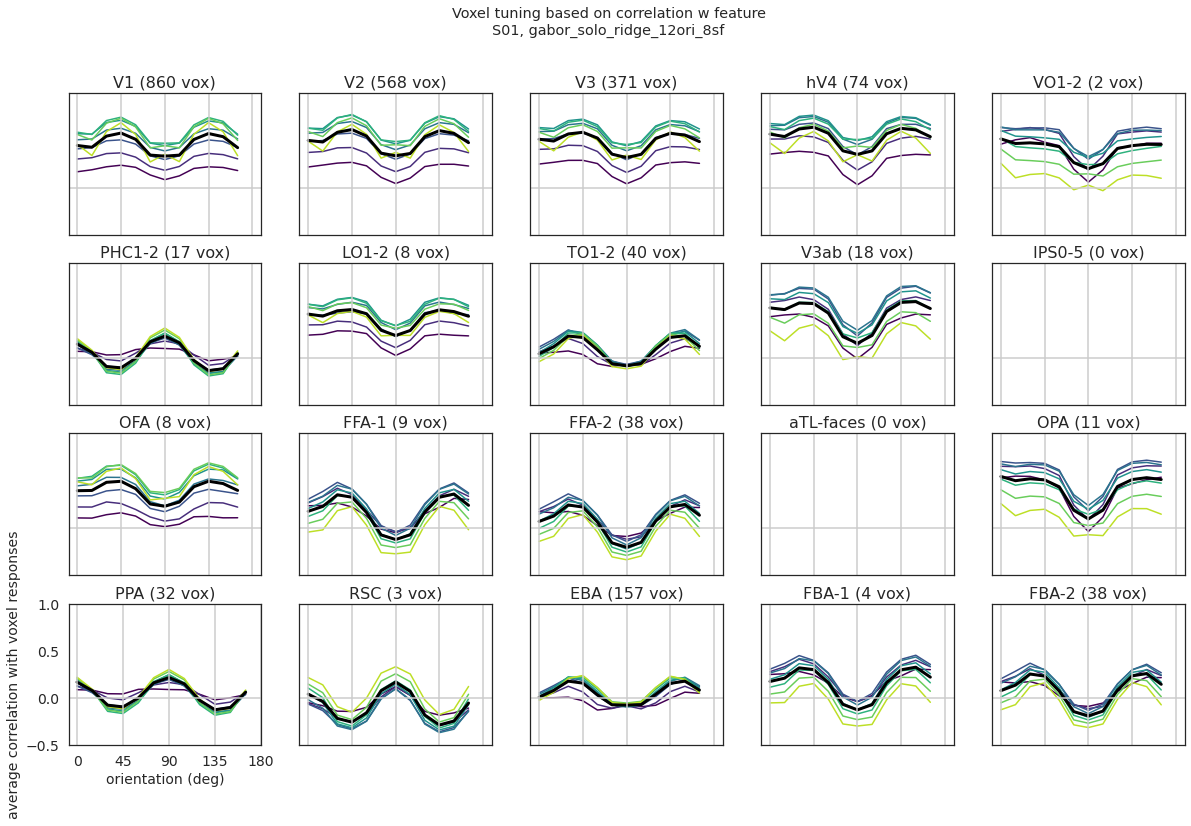

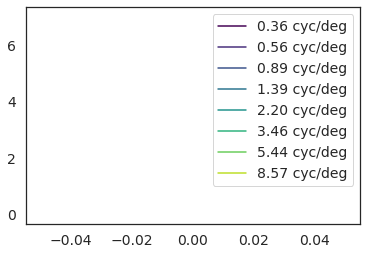

In [10]:
# Plot average orientation tuning curves for each ROI

r2_cutoff = 0.10
val_r2 = out['val_r2'][:,0]
abv_thresh = val_r2>r2_cutoff

plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_rois-len(skip_inds))))
npx = int(np.ceil((n_rois-len(skip_inds))/npy))

colors = cm.viridis(np.linspace(0,0.9,n_sf))

pi=0
for rr in range(n_rois):

    if rr not in skip_inds:
        if is_ret[rr]:
            inds_this_roi = retlabs==rr
            rname = ret_names[rr]
        elif is_face[rr]:
            inds_this_roi = facelabs==(rr-nret)
            rname = face_names[rr-nret]
        elif is_place[rr]:
            inds_this_roi = placelabs==(rr-nret-nface)
            rname = place_names[rr-nret-nface]
        elif is_body[rr]:
            inds_this_roi = bodylabs==(rr-nret-nface-nplace)
            rname = body_names[rr-nret-nface-nplace]

        inds_this_roi = inds_this_roi & abv_thresh
        pi+=1
        plt.subplot(npx,npy,pi)

        if np.sum(inds_this_roi)>0:
            for sf in range(n_sf):
                plt.plot(ori_deg, np.mean(allcorr_reshaped[inds_this_roi,:,sf], axis=0),\
                     '-',color=colors[sf,:])
            plt.plot(ori_deg,  np.mean(mean_orient_corr[inds_this_roi,:], axis=0),\
                     '-',color='k',linewidth=3)

        plt.axhline(0, color=[0.8, 0.8, 0.8])
        plt.ylim([-0.5,1])

        if pi==(npx-1)*npy+1:
            plt.xlabel('orientation (deg)')
            plt.ylabel('average correlation with voxel responses')
            plt.xticks(np.arange(0,181,45))
        else:
            plt.xticks([]);
            plt.yticks([])

        for ii in np.arange(0,181,45):
            plt.axvline(ii,color=[0.8, 0.8, 0.8])
    
        plt.title('%s (%d vox)'%(rname, np.sum(inds_this_roi)))

plt.suptitle('Voxel tuning based on correlation w feature\nS%02d, %s'%(subject, fitting_type));

plt.figure();
for sf in range(n_sf):
    plt.plot(0,sf,color=colors[sf,:])    
plt.legend(['%.2f cyc/deg'%sf_cyc_per_deg[sf] for sf in range(n_sf)]);


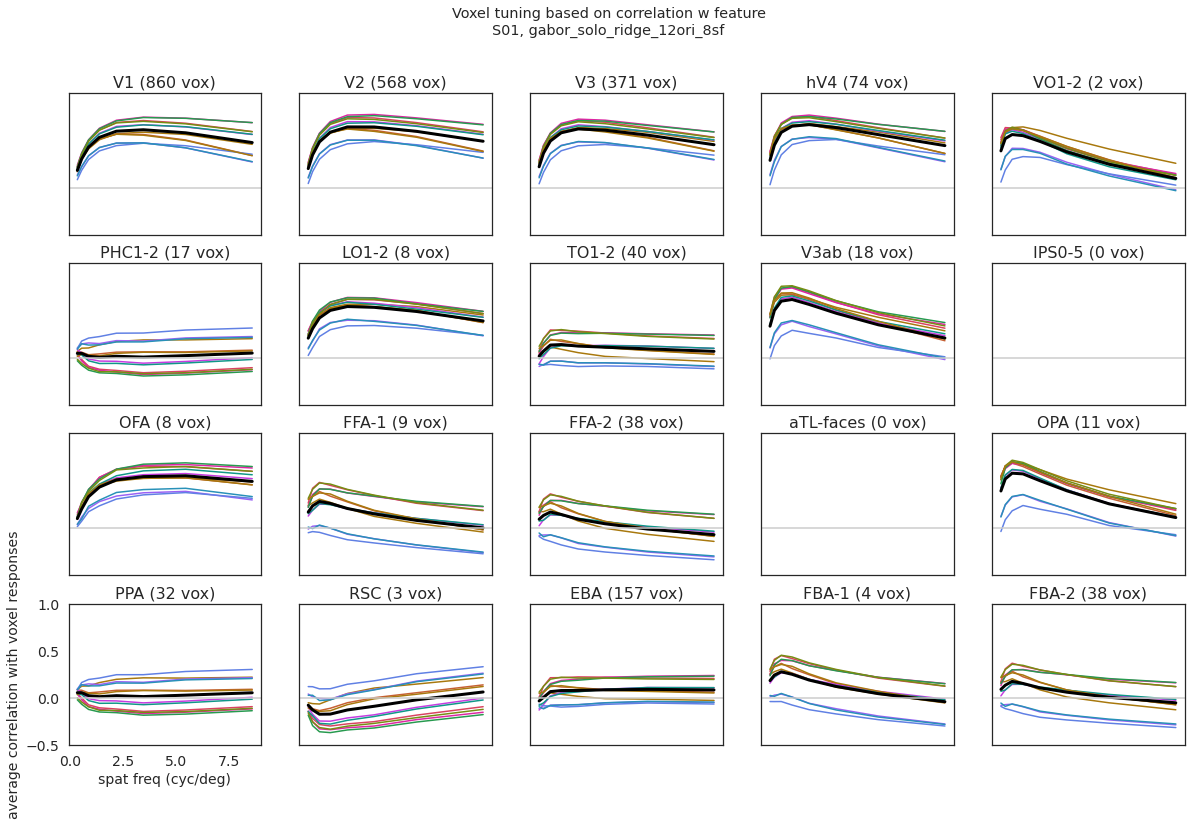

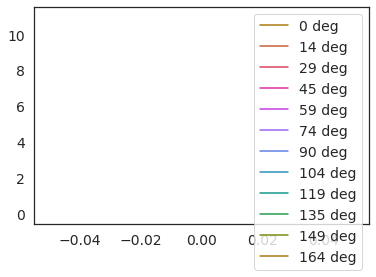

In [13]:
# Plot average spat freq tuning curves for each ROI

r2_cutoff = 0.10
val_r2 = out['val_r2'][:,0]
abv_thresh = val_r2>r2_cutoff

plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_rois-len(skip_inds))))
npx = int(np.ceil((n_rois-len(skip_inds))/npy))

colors = cmocean.cm.phase(np.linspace(0,1,n_ori))

pi=0
for rr in range(n_rois):

    if rr not in skip_inds:
        if is_ret[rr]:
            inds_this_roi = retlabs==rr
            rname = ret_names[rr]
        elif is_face[rr]:
            inds_this_roi = facelabs==(rr-nret)
            rname = face_names[rr-nret]
        elif is_place[rr]:
            inds_this_roi = placelabs==(rr-nret-nface)
            rname = place_names[rr-nret-nface]
        elif is_body[rr]:
            inds_this_roi = bodylabs==(rr-nret-nface-nplace)
            rname = body_names[rr-nret-nface-nplace]

        inds_this_roi = inds_this_roi & abv_thresh
        pi+=1
        plt.subplot(npx,npy,pi)

        if np.sum(inds_this_roi)>0:
            for oo in range(n_ori):
                plt.plot(sf_cyc_per_deg, np.mean(allcorr_reshaped[inds_this_roi,oo,:], axis=0).T,\
                     '-',color=colors[oo,:])
            plt.plot(sf_cyc_per_deg,  np.mean(mean_sf_corr[inds_this_roi,:], axis=0),\
                     '-',color='k',linewidth=3)

        plt.axhline(0, color=[0.8, 0.8, 0.8])
        plt.ylim([-0.5,1])

        if pi==(npx-1)*npy+1:
            plt.xlabel('spat freq (cyc/deg)')
            plt.ylabel('average correlation with voxel responses')
        else:
            plt.xticks([]);
            plt.yticks([])

        plt.title('%s (%d vox)'%(rname, np.sum(inds_this_roi)))

plt.suptitle('Voxel tuning based on correlation w feature\nS%02d, %s'%(subject, fitting_type));

plt.figure();
for oo in range(n_ori):
    plt.plot(0,oo,color=colors[oo,:])    
plt.legend(['%d deg'%ori_deg[oo] for oo in range(n_ori)]);


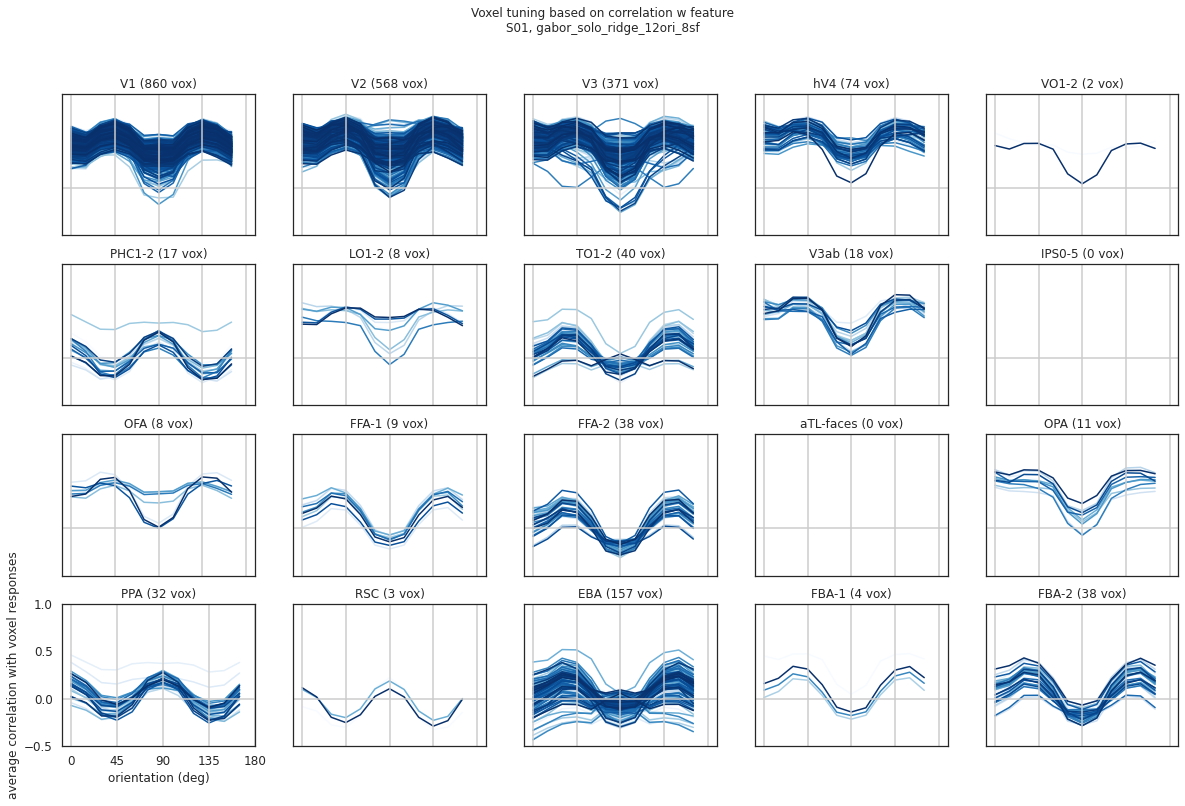

In [24]:
# Plot average orientation tuning curves for each ROI

r2_cutoff = 0.10
val_r2 = out['val_r2'][:,0]
abv_thresh = val_r2>r2_cutoff

plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_rois-len(skip_inds))))
npx = int(np.ceil((n_rois-len(skip_inds))/npy))

pi=0
for rr in range(n_rois):

    if rr not in skip_inds:
        if is_ret[rr]:
            inds_this_roi = retlabs==rr
            rname = ret_names[rr]
        elif is_face[rr]:
            inds_this_roi = facelabs==(rr-nret)
            rname = face_names[rr-nret]
        elif is_place[rr]:
            inds_this_roi = placelabs==(rr-nret-nface)
            rname = place_names[rr-nret-nface]
        elif is_body[rr]:
            inds_this_roi = bodylabs==(rr-nret-nface-nplace)
            rname = body_names[rr-nret-nface-nplace]

        inds_this_roi = inds_this_roi & abv_thresh
        pi+=1
        plt.subplot(npx,npy,pi)

        if np.sum(inds_this_roi)>0:
            vox2plot = np.where(inds_this_roi)[0]
            np.random.seed(982355)
            np.random.shuffle(vox2plot)
            colors = cm.Blues(np.linspace(0,1,len(vox2plot)))
            for vi,vv in enumerate(vox2plot):
                plt.plot(ori_deg, mean_orient_corr[vv,:].T,\
                     '-',color=colors[vi,:])
#             plt.plot(ori_deg,  np.mean(mean_orient_corr[inds_this_roi,:], axis=0),\
#                      '-',color='k')

        plt.axhline(0, color=[0.8, 0.8, 0.8])
        plt.ylim([-0.5,1])

        if pi==(npx-1)*npy+1:
            plt.xlabel('orientation (deg)')
            plt.ylabel('average correlation with voxel responses')
            plt.xticks(np.arange(0,181,45))
        else:
            plt.xticks([]);
            plt.yticks([])

        for ii in np.arange(0,181,45):
            plt.axvline(ii,color=[0.8, 0.8, 0.8])
    
        plt.title('%s (%d vox)'%(rname, np.sum(inds_this_roi)))

plt.suptitle('Voxel tuning based on correlation w feature\nS%02d, %s'%(subject, fitting_type));


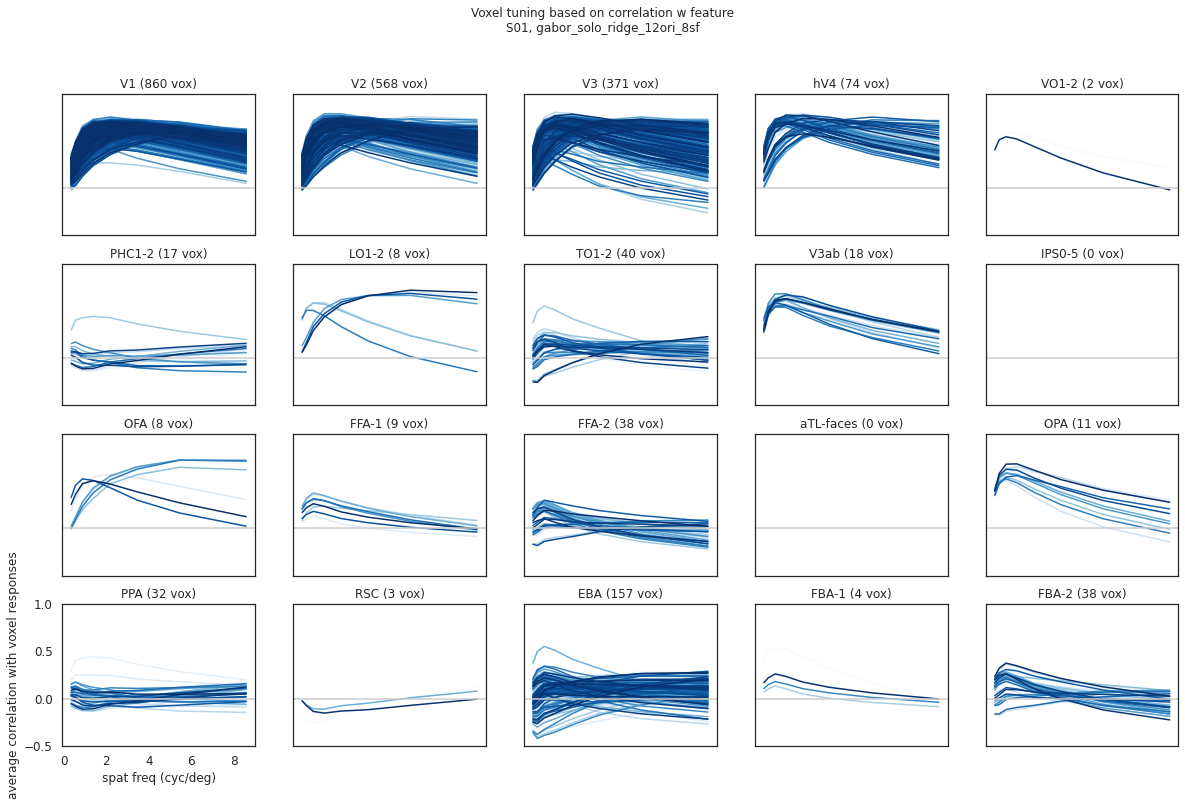

In [25]:
# Plot average spat freq tuning curves for each ROI

r2_cutoff = 0.10
val_r2 = out['val_r2'][:,0]
abv_thresh = val_r2>r2_cutoff

plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_rois-len(skip_inds))))
npx = int(np.ceil((n_rois-len(skip_inds))/npy))

pi=0
for rr in range(n_rois):

    if rr not in skip_inds:
        if is_ret[rr]:
            inds_this_roi = retlabs==rr
            rname = ret_names[rr]
        elif is_face[rr]:
            inds_this_roi = facelabs==(rr-nret)
            rname = face_names[rr-nret]
        elif is_place[rr]:
            inds_this_roi = placelabs==(rr-nret-nface)
            rname = place_names[rr-nret-nface]
        elif is_body[rr]:
            inds_this_roi = bodylabs==(rr-nret-nface-nplace)
            rname = body_names[rr-nret-nface-nplace]

        inds_this_roi = inds_this_roi & abv_thresh
        pi+=1
        plt.subplot(npx,npy,pi)

        if np.sum(inds_this_roi)>0:
            vox2plot = np.where(inds_this_roi)[0]
            np.random.seed(982355)
            np.random.shuffle(vox2plot)
            colors = cm.Blues(np.linspace(0,1,len(vox2plot)))
            for vi,vv in enumerate(vox2plot):
                plt.plot(sf_cyc_per_deg, mean_sf_corr[vv,:].T,\
                     '-',color=colors[vi,:])
            
#         plt.plot(sf_cyc_per_deg,  np.mean(mean_sf_corr[inds_this_roi,:], axis=0),\
#                  '-o',color='k')

        plt.axhline(0, color=[0.8, 0.8, 0.8])
        plt.ylim([-0.5,1])

        if pi==(npx-1)*npy+1:
            plt.xlabel('spat freq (cyc/deg)')
            plt.ylabel('average correlation with voxel responses')
        else:
            plt.xticks([]);
            plt.yticks([])

        plt.title('%s (%d vox)'%(rname, np.sum(inds_this_roi)))

plt.suptitle('Voxel tuning based on correlation w feature\nS%02d, %s'%(subject, fitting_type));


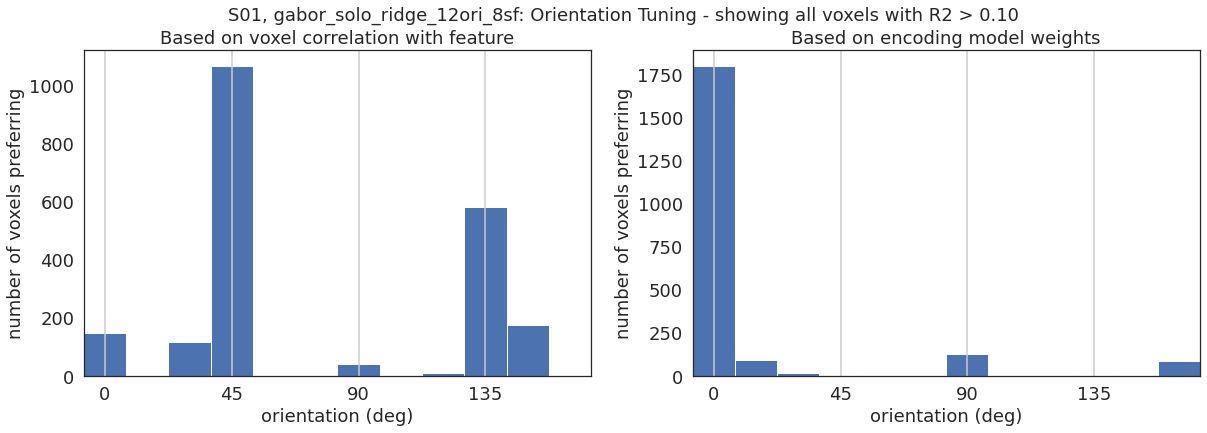

In [59]:
# Plot histogram of the orientation "tuning preferences" based on correlation coefficients
plt.figure(figsize=(20,6))

r2_cutoff = 0.10
val_r2 = out['val_r2'][:,0]
abv_thresh = val_r2>r2_cutoff

plt.subplot(1,2,1)
spacing = ori_deg[1] - ori_deg[0]
neach = [np.sum(preferred_ori_corr[abv_thresh]==oo) for oo in range(n_ori)]
plt.bar(ori_deg, neach, width=spacing)
plt.xticks(np.arange(0,181,45))
plt.xlim([-spacing/2,180-spacing/2])
plt.xlabel('orientation (deg)')
plt.ylabel('number of voxels preferring')
plt.title('Based on voxel correlation with feature')
for ii in np.arange(0,181,45):
    plt.axvline(ii,color=[0.8, 0.8, 0.8])
    
plt.subplot(1,2,2)
neach = [np.sum(preferred_ori_weights[abv_thresh]==oo) for oo in range(n_ori)]
plt.bar(ori_deg, neach, width=spacing)
plt.xticks(np.arange(0,181,45))
plt.xlim([-spacing/2,180-spacing/2])
plt.xlabel('orientation (deg)')
plt.ylabel('number of voxels preferring')
plt.title('Based on encoding model weights')
for ii in np.arange(0,181,45):
    plt.axvline(ii,color=[0.8, 0.8, 0.8])
     
plt.suptitle('S%02d, %s: Orientation Tuning - showing all voxels with R2 > %.2f'%(subject, fitting_type, r2_cutoff));

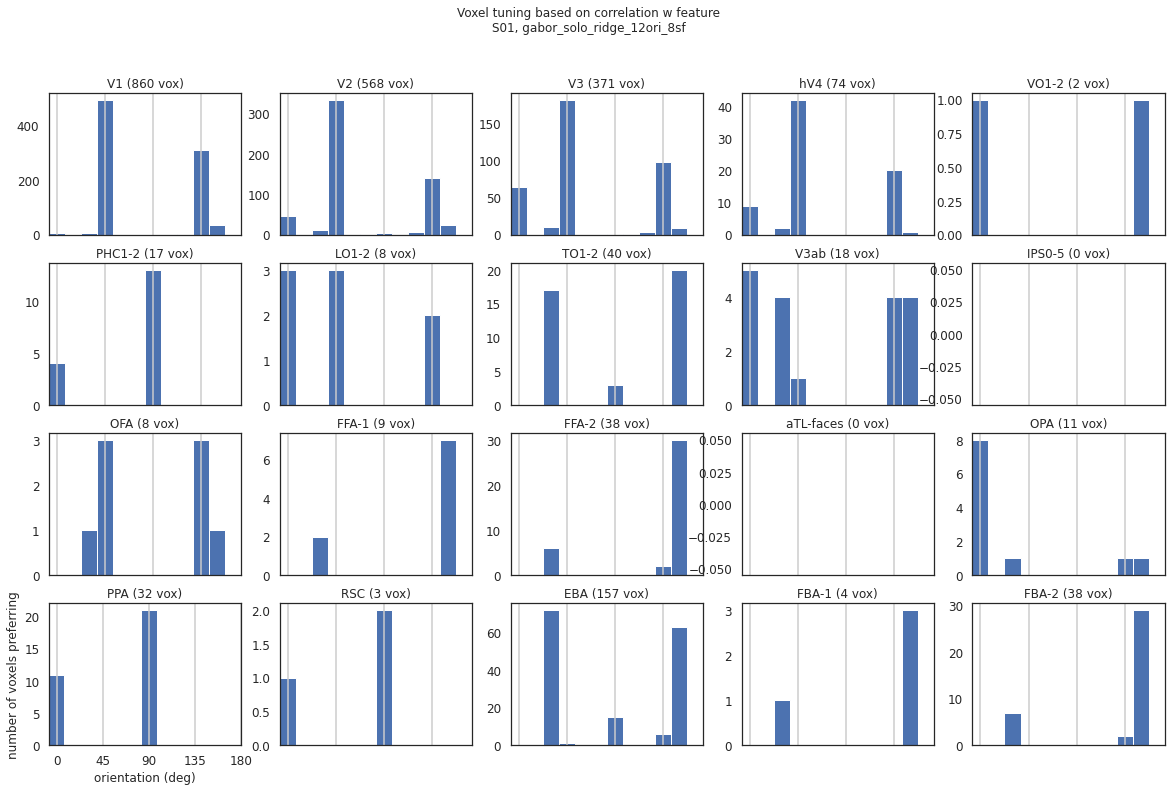

In [8]:

r2_cutoff = 0.10
val_r2 = out['val_r2'][:,0]
abv_thresh = val_r2>r2_cutoff


plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_rois-len(skip_inds))))
npx = int(np.ceil((n_rois-len(skip_inds))/npy))

pi=0
for rr in range(n_rois):

    if rr not in skip_inds:
        if is_ret[rr]:
            inds_this_roi = retlabs==rr
            rname = ret_names[rr]
        elif is_face[rr]:
            inds_this_roi = facelabs==(rr-nret)
            rname = face_names[rr-nret]
        elif is_place[rr]:
            inds_this_roi = placelabs==(rr-nret-nface)
            rname = place_names[rr-nret-nface]
        elif is_body[rr]:
            inds_this_roi = bodylabs==(rr-nret-nface-nplace)
            rname = body_names[rr-nret-nface-nplace]

        inds_this_roi = inds_this_roi & abv_thresh
        pi+=1
        plt.subplot(npx,npy,pi)

        spacing = ori_deg[1] - ori_deg[0]
        neach = [np.sum(preferred_ori_corr[inds_this_roi]==oo) for oo in range(n_ori)]
        plt.bar(ori_deg, neach, width=spacing)
        
        plt.xlim([-spacing/2,180-spacing/2])

#         print(pi)
        if pi==(npx-1)*npy+1:
            plt.xlabel('orientation (deg)')
            plt.ylabel('number of voxels preferring')
            plt.xticks(np.arange(0,181,45))
        else:
            plt.xticks([]);
    #         plt.yticks([])

        for ii in np.arange(0,181,45):
            plt.axvline(ii,color=[0.8, 0.8, 0.8])
    
        plt.title('%s (%d vox)'%(rname, np.sum(inds_this_roi)))

plt.suptitle('Voxel tuning based on correlation w feature\nS%02d, %s'%(subject, fitting_type));


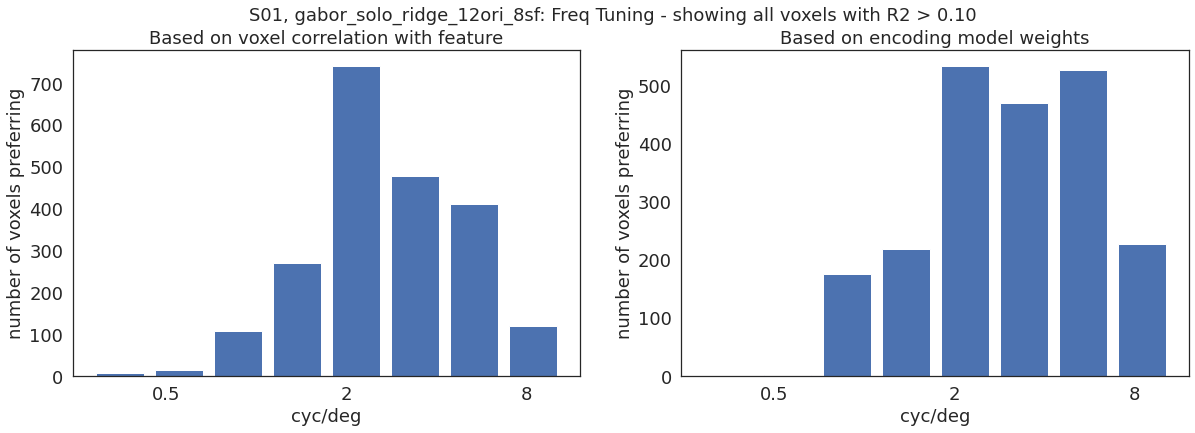

In [63]:
# Plot histogram of the orientation "tuning preferences" based on correlation coefficients
plt.figure(figsize=(20,6))

r2_cutoff = 0.10
val_r2 = out['val_r2'][:,0]
abv_thresh = val_r2>r2_cutoff

plt.subplot(1,2,1)
spacing = np.diff(sf_cyc_per_deg)
if len(spacing)>1:
    dlog = np.log(spacing[1]) - np.log(spacing[0])                
else:
    dlog = np.log(sf_cyc_per_deg[1]) - np.log(sf_cyc_per_deg[0])
    plt.xlim([10**np.log10(0.1), 10**np.log10(14)])
spacing = np.concatenate([[np.exp(np.log(spacing[0]) - dlog)], spacing])
neach = [np.sum(preferred_sf_corr[abv_thresh]==sf) for sf in range(n_sf)]
plt.bar(sf_cyc_per_deg, neach, width=spacing)
plt.gca().set_xscale('log')
plt.xticks([10**np.log10(0.5), 10**np.log10(2),10**np.log10(8)],\
                       [0.5, 2,8])
plt.xlabel('cyc/deg')
plt.ylabel('number of voxels preferring')
plt.title('Based on voxel correlation with feature')

plt.subplot(1,2,2)
spacing = np.diff(sf_cyc_per_deg)
if len(spacing)>1:
    dlog = np.log(spacing[1]) - np.log(spacing[0])                
else:
    dlog = np.log(sf_cyc_per_deg[1]) - np.log(sf_cyc_per_deg[0])
    plt.xlim([10**np.log10(0.1), 10**np.log10(14)])
spacing = np.concatenate([[np.exp(np.log(spacing[0]) - dlog)], spacing])
neach = [np.sum(preferred_sf_weights[abv_thresh]==sf) for sf in range(n_sf)]
plt.bar(sf_cyc_per_deg, neach, width=spacing)
plt.gca().set_xscale('log')
plt.xticks([10**np.log10(0.5), 10**np.log10(2),10**np.log10(8)],\
                       [0.5, 2,8])
plt.xlabel('cyc/deg')
plt.ylabel('number of voxels preferring')
plt.title('Based on encoding model weights')

plt.suptitle('S%02d, %s: Freq Tuning - showing all voxels with R2 > %.2f'%(subject, fitting_type, r2_cutoff));

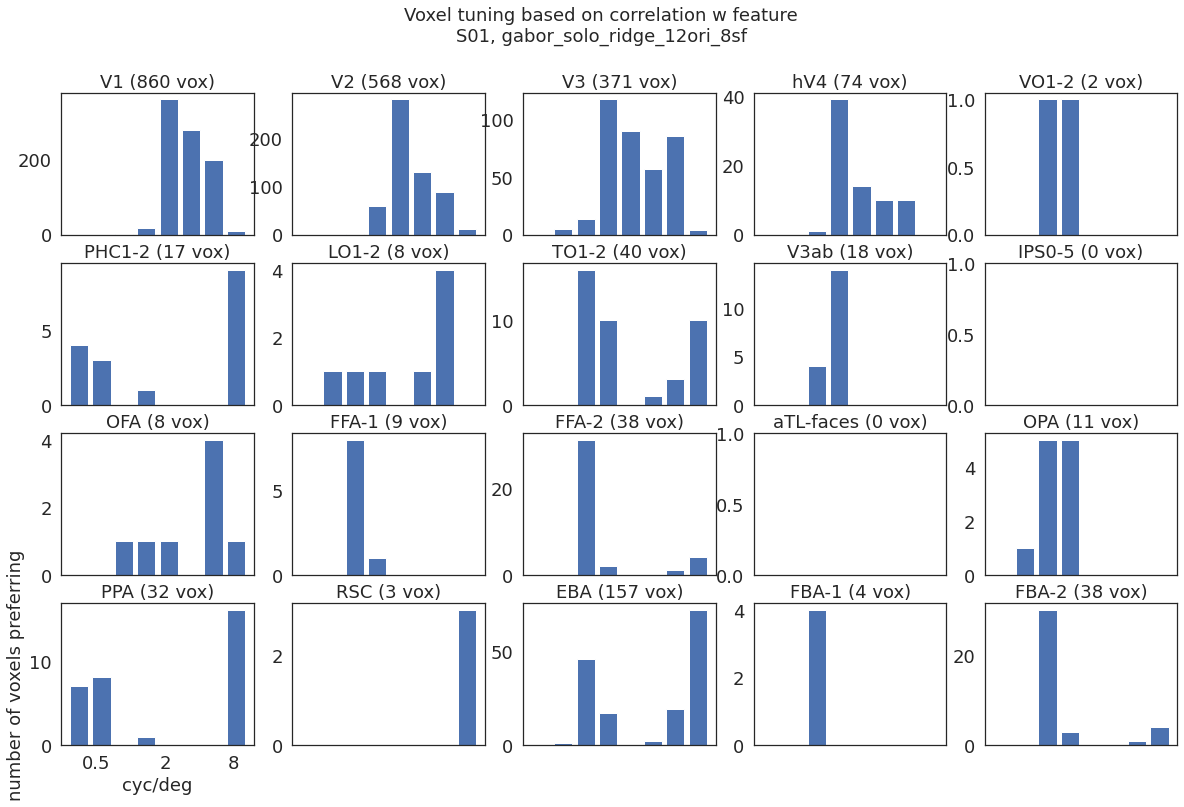

In [64]:

r2_cutoff = 0.10
val_r2 = out['val_r2'][:,0]
abv_thresh = val_r2>r2_cutoff


plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_rois-len(skip_inds))))
npx = int(np.ceil((n_rois-len(skip_inds))/npy))

pi=0
for rr in range(n_rois):

    if rr not in skip_inds:
        if is_ret[rr]:
            inds_this_roi = retlabs==rr
            rname = ret_names[rr]
        elif is_face[rr]:
            inds_this_roi = facelabs==(rr-nret)
            rname = face_names[rr-nret]
        elif is_place[rr]:
            inds_this_roi = placelabs==(rr-nret-nface)
            rname = place_names[rr-nret-nface]
        elif is_body[rr]:
            inds_this_roi = bodylabs==(rr-nret-nface-nplace)
            rname = body_names[rr-nret-nface-nplace]

        pi+=1
        plt.subplot(npx,npy,pi)
        inds_this_roi = inds_this_roi & abv_thresh
        if np.any(inds_this_roi):


            spacing = np.diff(sf_cyc_per_deg)            
            if len(spacing)>1:
                dlog = np.log(spacing[1]) - np.log(spacing[0])                
            else:
                dlog = np.log(sf_cyc_per_deg[1]) - np.log(sf_cyc_per_deg[0])
                plt.xlim([10**np.log10(0.1), 10**np.log10(14)])
            spacing = np.concatenate([[np.exp(np.log(spacing[0]) - dlog)], spacing])
            neach = [np.sum(preferred_sf_corr[inds_this_roi]==sf) for sf in range(n_sf)]
            plt.bar(sf_cyc_per_deg, neach, width=spacing)
    #         plt.bar(sf_cyc_per_deg, neach)
    #         plt.plot(sf_cyc_per_deg, neach, '.', color='k')
            
        plt.gca().set_xscale('log')
        if pi==(npx-1)*npy+1:
            plt.xlabel('cyc/deg')
            plt.ylabel('number of voxels preferring')
            plt.xticks([10**np.log10(0.5), 10**np.log10(2),10**np.log10(8)],\
                       [0.5, 2,8])
        else:
            plt.xticks([]);
        #         plt.yticks([])

    #         for ii in np.arange(0,181,45):
    #             plt.axvline(ii,color=[0.8, 0.8, 0.8])

        plt.title('%s (%d vox)'%(rname, np.sum(inds_this_roi)))

plt.suptitle('Voxel tuning based on correlation w feature\nS%02d, %s'%(subject, fitting_type));


In [65]:
discrim_each_axis = out['discrim_each_axis']
discrim_type_list = ['indoor_outdoor','animacy','person','food','vehicle','animal']
n_sem_axes = len(discrim_type_list)
mean_discrim_each_roi = np.zeros((n_rois, n_sem_axes))

for rr in range(n_rois):
    if rr not in skip_inds:
        if is_ret[rr]:
            inds_this_roi = retlabs==rr
        elif is_face[rr]:
            inds_this_roi = facelabs==(rr-nret)
        elif is_place[rr]:
            inds_this_roi = placelabs==(rr-nret-nface)
        elif is_body[rr]:
            inds_this_roi = bodylabs==(rr-nret-nface-nplace)
        mean_discrim_each_roi[rr,:] = np.mean(np.abs(discrim_each_axis[inds_this_roi,:]), axis=0)
    else:
        mean_discrim_each_roi[rr,:] = np.nan

In [187]:
np.any(np.sum(np.isnan(discrim_each_axis), axis=1))

False

In [186]:
out['which_prf_grid']

5

In [188]:
out['up_to_sess']

40

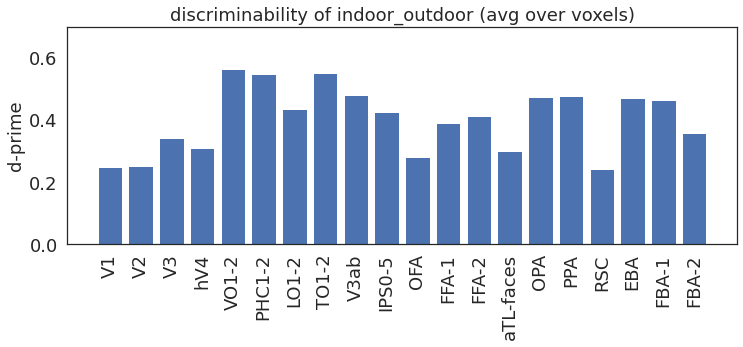

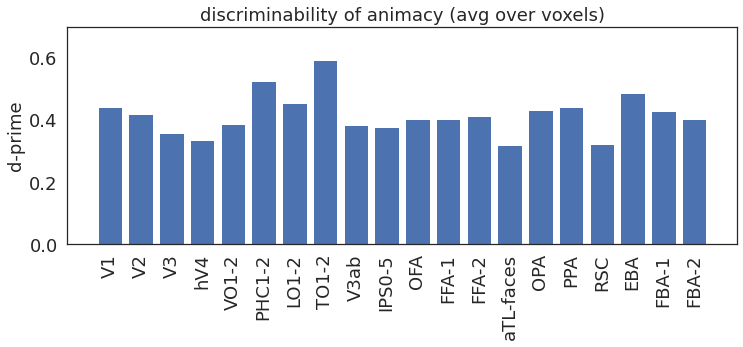

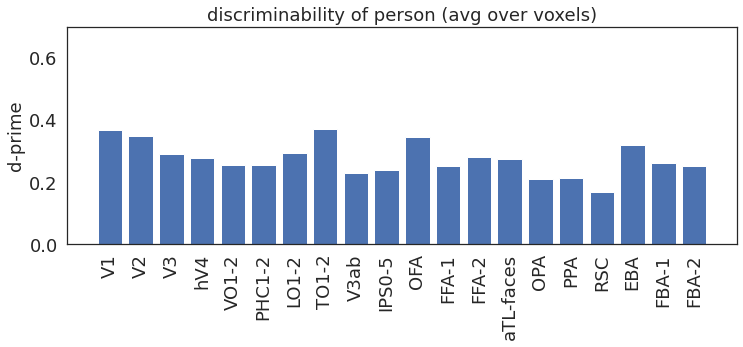

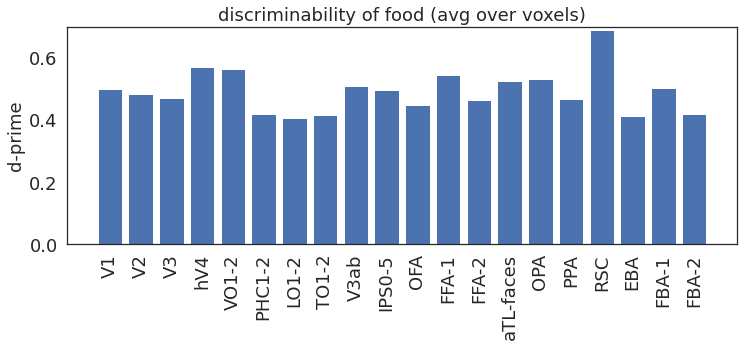

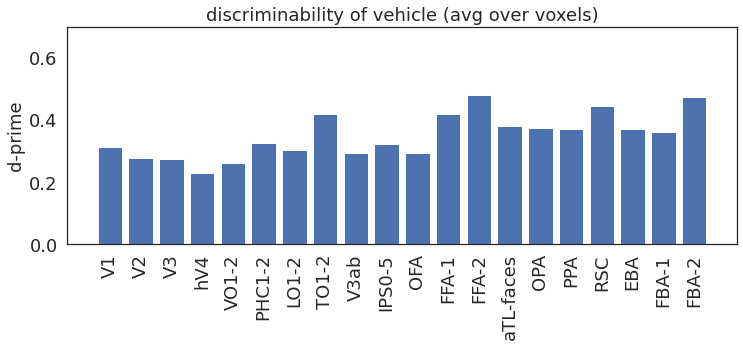

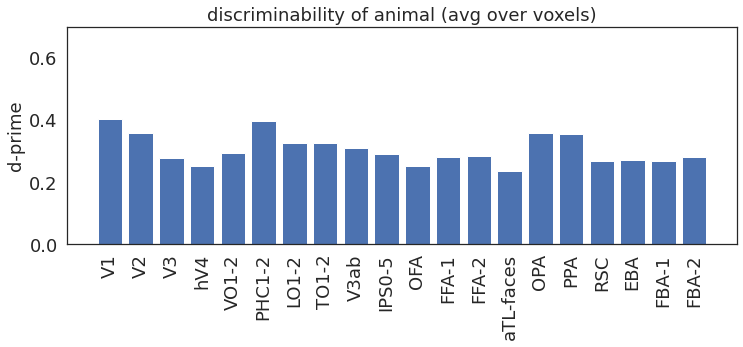

In [66]:

for aa, discrim_type in enumerate(discrim_type_list):
    plt.figure(figsize=(12,4));
    inds2use = ~np.isin(np.arange(n_rois), skip_inds)
#     inds2use = ~np.isnan(dprime_vals[:,aa])
    n_rois_plot = np.sum(inds2use)
    plt.bar(np.arange(n_rois_plot),mean_discrim_each_roi[inds2use,aa])
    plt.xticks(np.arange(n_rois_plot), labels=np.array(roi_names)[inds2use], rotation=90);
    plt.ylabel('d-prime')
    plt.title('discriminability of %s (avg over voxels)'%discrim_type)
    plt.ylim([0,0.7])

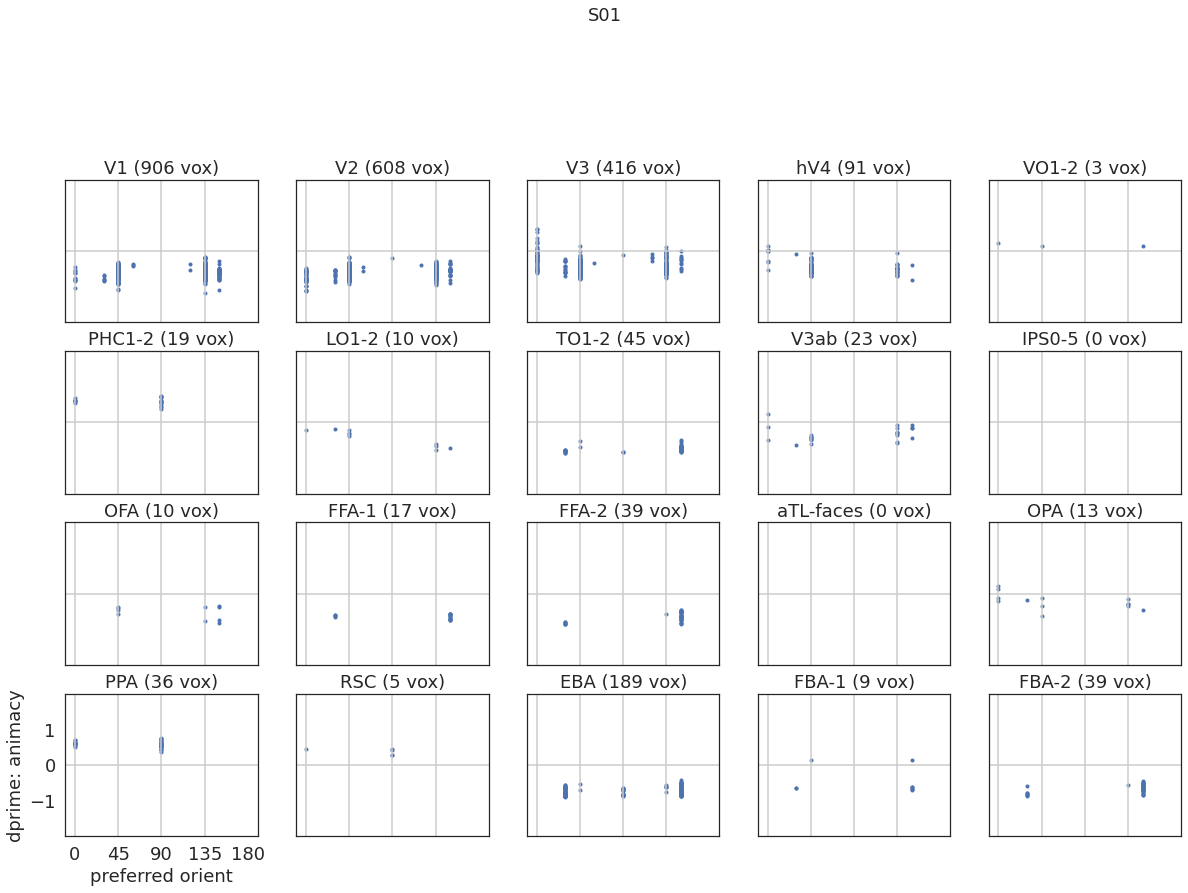

In [107]:
plot_utils.set_all_font_sizes(fs = 18)
r2_cutoff = 0.10
dd = 1
val1 = ori_deg[preferred_ori_corr.astype(int)]
val2 = out['discrim_each_axis'][:,dd]
dat = np.concatenate((val1[:,np.newaxis],val2[:,np.newaxis]), axis=1)

inds2use = out['val_r2'][:,0]>r2_cutoff

sp = plot_utils.scatter_plot(color=None, xlabel='preferred orient', \
                             ylabel='dprime: %s'%discrim_type_list[dd], \
                             xlims=[-10,190], ylims=[-2,2], \
                  xticks=np.arange(0,181,45), yticks=([-1,0,1]),\
                  show_diagonal=False, show_axes=True, square=False);

plot_utils.create_roi_subplots(dat, inds2use, sp, subject, out,\
                    suptitle='S%02d'%(subject), \
                   label_just_corner=True, figsize=(20,24), roi_def=roi_def, skip_inds=skip_inds)

plt.gcf().subplots_adjust(bottom=0.5)
axes = plt.gcf().get_axes();
for ax in axes:
    for ii in np.arange(45,136,45):
        ax.axvline(ii, color=[0.8, 0.8, 0.8])
#     print(ax)
#     plt.axvline(90, figure=ax);

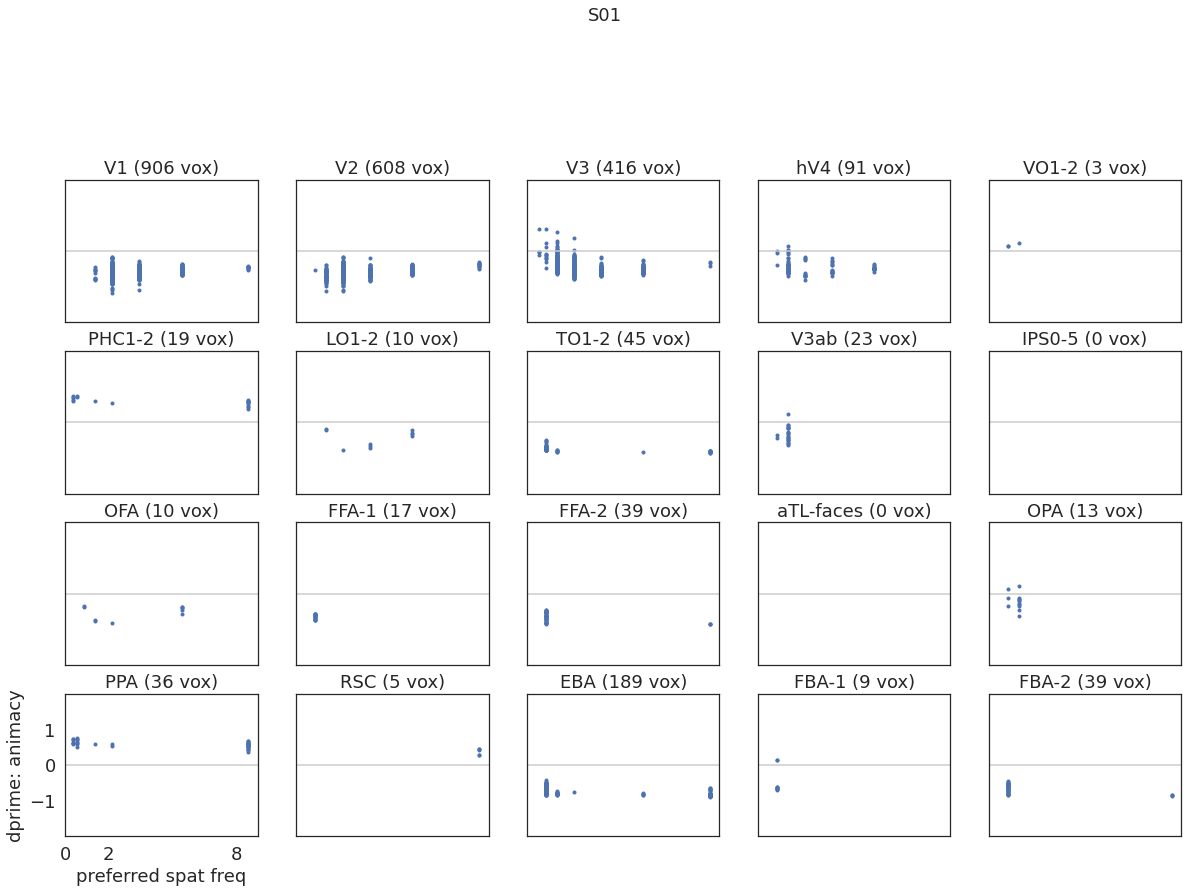

In [108]:
plot_utils.set_all_font_sizes(fs = 18)
r2_cutoff = 0.10
dd = 1
val1 = sf_cyc_per_deg[preferred_sf_corr.astype(int)]
val2 = out['discrim_each_axis'][:,dd]
dat = np.concatenate((val1[:,np.newaxis],val2[:,np.newaxis]), axis=1)

inds2use = out['val_r2'][:,0]>r2_cutoff

sp = plot_utils.scatter_plot(color=None, xlabel='preferred spat freq', \
                             ylabel='dprime: %s'%discrim_type_list[dd], \
                             xlims=[0,9], ylims=[-2,2], \
                  xticks=[0,2,8], yticks=([-1,0,1]),\
                  show_diagonal=False, show_axes=True, square=False);

plot_utils.create_roi_subplots(dat, inds2use, sp, subject, out,\
                    suptitle='S%02d'%(subject), \
                   label_just_corner=True, figsize=(20,24), roi_def=roi_def, skip_inds=skip_inds)

plt.gcf().subplots_adjust(bottom=0.5)
axes = plt.gcf().get_axes();
# for ax in axes:
#     for ii in np.arange(45,136,45):
#         ax.axvline(ii, color=[0.8, 0.8, 0.8])
#     print(ax)
#     plt.axvline(90, figure=ax);

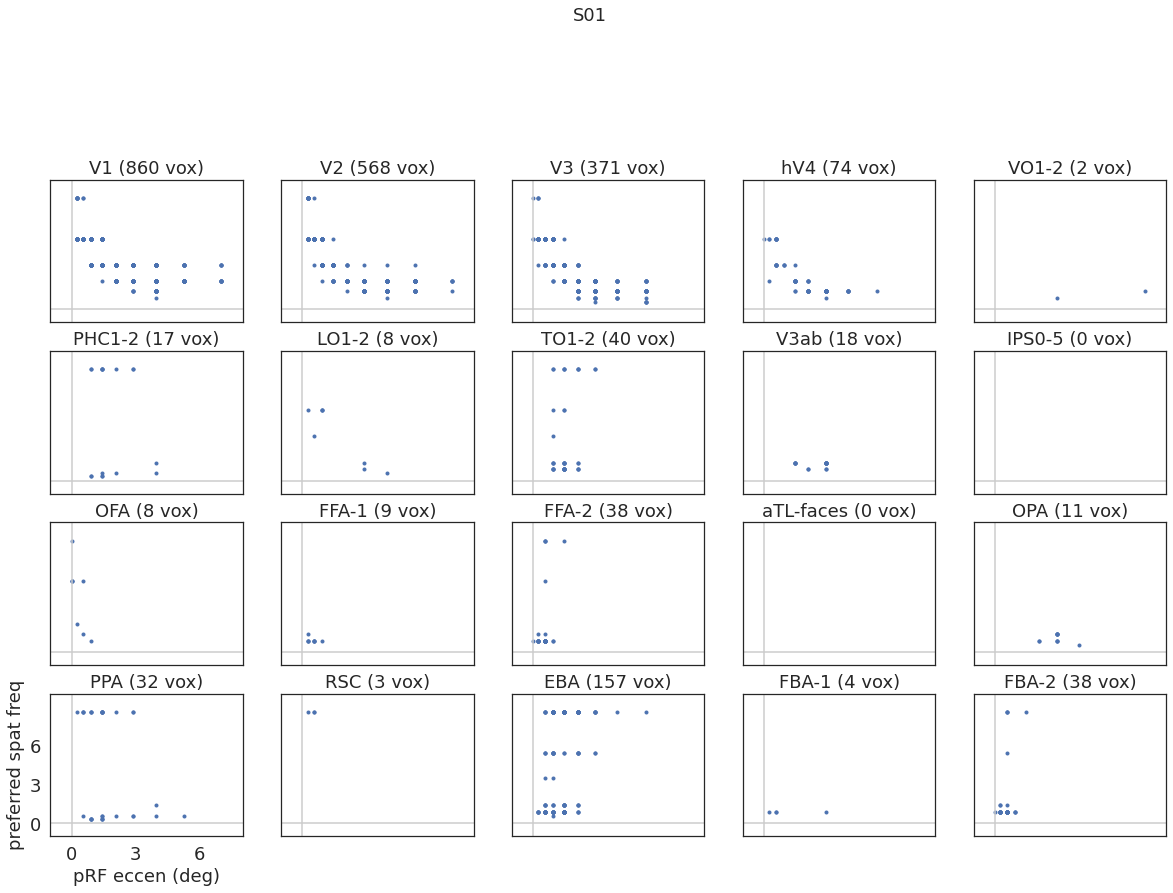

In [28]:
plot_utils.set_all_font_sizes(fs = 18)
r2_cutoff = 0.10

best_ecc_deg, best_angle_deg, best_size_deg = plot_prf_params.get_prf_pars_deg(out, screen_eccen_deg=8.4)

val1 = best_ecc_deg
val2 = sf_cyc_per_deg[preferred_sf_corr.astype('int')]
dat = np.concatenate((val1[:,np.newaxis],val2[:,np.newaxis]), axis=1)

inds2use = out['val_r2'][:,0]>r2_cutoff

sp = plot_utils.scatter_plot(color=None, xlabel='pRF eccen (deg)', \
                             ylabel='preferred spat freq', \
                             xlims=[-1,8], ylims=[-1,10], \
                  xticks=[0,3,6], yticks=([0,3,6]),\
                  show_diagonal=False, show_axes=True, square=False);

plot_utils.create_roi_subplots(dat, inds2use, sp, subject, out,\
                    suptitle='S%02d'%(subject), \
                   label_just_corner=True, figsize=(20,24), roi_def=roi_def, skip_inds=skip_inds)

plt.gcf().subplots_adjust(bottom=0.5)
axes = plt.gcf().get_axes();
# for ax in axes:
#     for ii in np.arange(45,136,45):
#         ax.axvline(ii, color=[0.8, 0.8, 0.8])
#     print(ax)
#     plt.axvline(90, figure=ax);

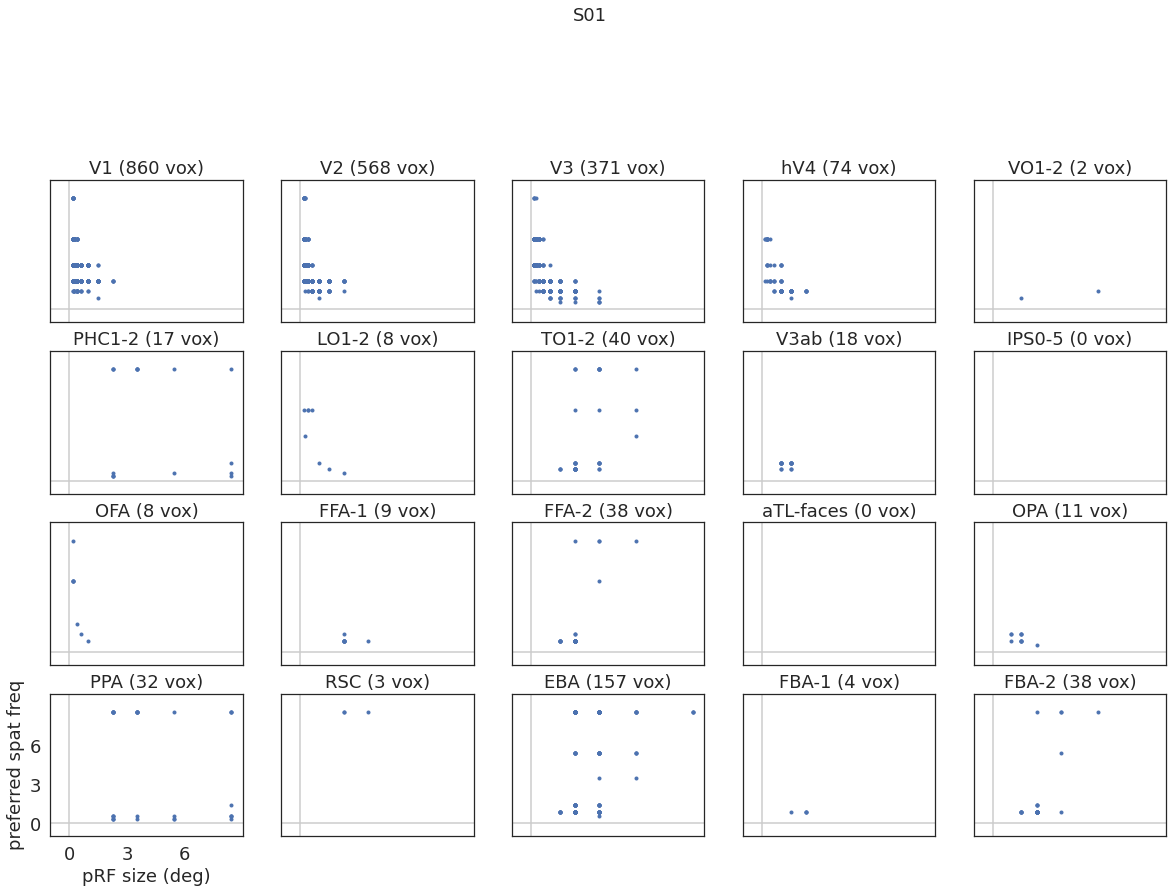

In [29]:
plot_utils.set_all_font_sizes(fs = 18)
r2_cutoff = 0.10

best_ecc_deg, best_angle_deg, best_size_deg = plot_prf_params.get_prf_pars_deg(out, screen_eccen_deg=8.4)
val1 = best_size_deg
val2 = sf_cyc_per_deg[preferred_sf_corr.astype(int)]
dat = np.concatenate((val1[:,np.newaxis],val2[:,np.newaxis]), axis=1)

inds2use = out['val_r2'][:,0]>r2_cutoff

sp = plot_utils.scatter_plot(color=None, xlabel='pRF size (deg)', \
                             ylabel='preferred spat freq', \
                             xlims=[-1,9], ylims=[-1,10], \
                  xticks=[0,3,6], yticks=([0,3,6]),\
                  show_diagonal=False, show_axes=True, square=False);

plot_utils.create_roi_subplots(dat, inds2use, sp, subject, out,\
                    suptitle='S%02d'%(subject), \
                   label_just_corner=True, figsize=(20,24), roi_def=roi_def, skip_inds=skip_inds)

plt.gcf().subplots_adjust(bottom=0.5)
axes = plt.gcf().get_axes();
# for ax in axes:
#     for ii in np.arange(45,136,45):
#         ax.axvline(ii, color=[0.8, 0.8, 0.8])
#     print(ax)
#     plt.axvline(90, figure=ax);